# Abstract

Although control of the Senate has always been an important goal for both major parties, 2020 has thrown this battle into the spotlight. Because of the importance of these races, it might be useful to know if a person's vote can be predicted by gathering information about them and their state. To answer this questions we gathered demographic, economic, and election information for all states from various sources with a previously conducted survey of voters. Data were collected from a variety of sources. We set out to predict whether someone registered with one of the two major parties would defect and how independents would vote. In both cases, a random forest model was the most accurate. 

We can achieve 92% accuracy in predicting whether registered Democrats and Republicans will vote with their party in Senate races and 91% accuracy in predicting which candidate people registered with each party voted for. While in both cases having a higher population and being younger was associated with voting for a Democrat and views of other elected officials were very influential, there were some differences. For major-party-affiliated voters, a higher percentage of non-white individuals living in their state and increased population density and percentage of non-citizens was associated with Democrats defecting to the Republican party while the opposite was true for Democrats who voted for a Republican. Meanwhile unemployment was a significant factor with independent voters, who typically voted for Republicans when unemployment was high.  

# Introduction

&nbsp;&nbsp;&nbsp; While the Senate has always been crucial to any political party's success, 2020 has shown just how influential the outcomes of Senate races are. From steering the course of American law via the <a href="https://www.cnn.com/politics/live-news/amy-coney-barrett-senate-confirmation-vote/index.html" target="_blank">confirmation of Supreme Court justices</a> to deciding how <a href="https://www.politico.com/news/2020/12/01/bipartisan-senate-coronavirus-stimulus-441742" target="_blank">pandemic relief</a> is distributed, control of the Senate is a political necessity for either party. Therefore it is useful to know what factors make a difference in voters' choices in Senate races. We combined data on states' demographic makeup, voter participation, election laws, economic position, and year-related factors with survey data collected by the <a href="https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi%3A10.7910/DVN/II2DB6" target="_blank"> Cooperative Congressional Election Study</a>. We set out to answer three questions. First, can we use these variables to predict someone's party identification? Secondly, can we identify major-party identified voters who will defect from their stated party and determine what factors are indicators of this phenomenon? Finally, when we include all voters who do not vote with their party, can we identify these voters?          

# Data Sources

There was a large compilation of state policy and demographic variables made available by the Michigan State University that was used in this project. Senate data by year and voting eligible population data was found on data.world. However there was not consistent data across years. For population level variables, we turned mostly to the Census Bureau, sorting through their tables from each year. However we also used data from the Kaiser Family Foundation, the Congressional Research Service, Iowa State University, and Harvard’s dataverse to fill in missing data. We also used a large-scale survey of voters in the Harvard dataverse. 

Some variables, such as which places were impacted by the Supreme Court case Shelby v Holder, were not available in the form of a data table and simply researched to understand which states were affected and what impact the case had on these states’ elections. Other variables, such as each state’s policy on voter ID and other such laws in recent years, had to be manually inputted. Thanks to various news articles and the National Conference of State Legislatures, we were able to pinpoint when changes in the laws occurred and input the data accordingly. In addition we scrapped unemployment data that had not being compiled and put in a downloadable form from the U.S. Bureau of Labor Statistics. 

All data is linked when used and sources are cited for the appropriate works at the bottom of this notebook. 

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
pd.set_option("display.max_rows", 500, "display.max_columns", 200)
from bs4 import BeautifulSoup
import requests
import re
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

# Data Cleaning

## Voter Turnout

We start with <a href="https://data.world/government/vep-turnout" target="_blank"> voter turnout data </a> from 1980-2018. These datasets provide the number of voting eligible and voting age individuals in each state for each year. There are also estimations of the number of people ineligible to vote due to felonies or lack of citizenship. There are other variables included in the dataset but they are not relevant to our inquiry.  
- First we can read in and examine the three datasets: turnout from 1980-2014, turnout in 2016, and turnout in 2018.  

In [2]:
turnout_to_14 = pd.read_csv("1980-2014 November General Election - Turnout Rates.csv")
turnout_16 = pd.read_csv("2016 November General Election - Turnout Rates.csv")
turnout_18 = pd.read_csv("2018 November General Election - Turnout Rates.csv")

In [3]:
turnout_to_14.head()

,Year,ICPSR State Code,Alphanumeric State Code,State,VEP Total Ballots Counted,VEP Highest Office,VAP Highest Office,Total Ballots Counted,Highest Office,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon,Overseas Eligible
0,2014,0,0,United States,36.70%,36.00%,33.20%,"83,262,122","81,687,059","227,157,964","245,712,915",8.40%,"1,493,706","2,298,993","548,576","3,329,718","5,345,814"
1,2014,41,1,Alabama,33.20%,32.90%,31.50%,"1,191,274","1,180,413","3,588,783","3,751,844",2.50%,"31,691","53,640","8,097","69,826",NaN
2,2014,81,2,Alaska,54.80%,54.20%,51.00%,"285,431","282,382","520,562","553,473",3.90%,"5,216","7,077","2,210","11,389",NaN
3,2014,61,3,Arizona,34.10%,33.40%,29.50%,"1,537,671","1,506,416","4,510,186","5,110,890",10.10%,"37,516","73,232","7,502","86,028",NaN
4,2014,42,4,Arkansas,40.30%,40.10%,37.50%,"852,642","848,592","2,117,881","2,263,040",4.00%,"17,756","28,192","21,743","55,287",NaN


In [4]:
turnout_16.head()

,State,State Results Website,Status,VEP Total Ballots Counted,VEP Highest Office,VAP Highest Office,Total Ballots Counted (Estimate),Highest Office,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon,Overseas Eligible,State Abv
0,United States,NaN,NaN,60.10%,59.20%,54.70%,"138,846,571","136,753,936","230,931,921","250,055,734",8.30%,"1,416,810","2,198,907","506,297","3,176,484","4,739,596",NaN
1,Alabama,http://www.alabamavotes.gov/downloads/election...,Official,59.10%,58.80%,56.30%,"2,134,061","2,123,372","3,609,447","3,770,142",2.50%,"28,680","52,177","8,562","66,983",NaN,AL
2,Alaska,http://www.elections.alaska.gov/results/16GENR/,Official,61.50%,61.00%,57.40%,"321,271","318,608","522,679","555,367",4.10%,"4,317","6,621","1,812","9,903",NaN,AK
3,Arizona,http://apps.azsos.gov/election/2016/General/Of...,Official,56.10%,54.90%,48.90%,"2,661,497","2,604,657","4,740,310","5,331,034",9.40%,"37,582","77,373","7,500","89,185",NaN,AZ
4,Arkansas,http://results.enr.clarityelections.com/AR/639...,Official,53.20%,52.80%,49.40%,"1,137,772","1,130,635","2,140,097","2,286,625",3.80%,"17,242","30,881","23,792","58,636",NaN,AR


In [5]:
turnout_18.head()

,State,Estimated or Actual 2018 Total Ballots Counted VEP Turnout Rate,2018 Vote for Highest Office VEP Turnout Rate,Status,Source,Estimated or Actual 2018 Total Ballots Counted,2018 Vote for Highest Office,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon,Overseas Eligible,State Abv
0,United States,50.00%,49.40%,NaN,NaN,"118,581,921","117,069,210","237,089,672","255,801,552",7.90%,"1,416,810","2,126,035","494,442","3,264,172","4,793,402",NaN
1,Alabama,47.00%,46.90%,Certified,https://www.sos.alabama.gov/sites/default/file...,"1,721,906","1,719,589","3,666,511","3,820,544",2.30%,"28,680","52,177","8,562","66,983",NaN,AL
2,Alaska,54.80%,54.50%,Official,http://www.elections.alaska.gov/results/18GENR/,"285,009","283,134","519,913","551,451",3.90%,"4,317","6,621","1,812","9,903",NaN,AK
3,Arizona,47.40%,46.90%,Certified,https://azsos.gov/sites/default/files/2018%201...,"2,409,910","2,384,308","5,082,126","5,678,479",8.90%,"37,582","77,373","7,500","89,185",NaN,AZ
4,Arkansas,41.30%,41.00%,Official,https://results.enr.clarityelections.com/AR/92...,"898,793","891,509","2,176,226","2,321,029",3.70%,"17,242","30,881","23,792","58,636",NaN,AR


- We do not need the administrative codes, nor the full state name.
- Since we are only interested in senate races, we do not need to know the numbers associated with highest office, since that is sometimes president.
- For now we will only keep the raw totals for Voting-Eligible Population and Voting-Age Population as well information about non-citizens, incarceration, and overseas.
- Since not everyone who voted may not have voted for a senate candidate, we will get rid of the total ballots counted an use our first dataset. 

In [6]:
#First we will remove some columns from the 1980-2014 dataset
turnout_to_14 = turnout_to_14.drop(columns=["ICPSR State Code", "Alphanumeric State Code", 
                                            "VEP Total Ballots Counted", "VEP Highest Office",
                                            "VAP Highest Office", "Highest Office", "Total Ballots Counted"])

#We can also remove the rows where the total United States or DC is being counted and the data frrom before 1984
turnout_to_14 = turnout_to_14[(turnout_to_14["State"] != "United States") & 
                              (turnout_to_14["State"] != "District of Columbia") &
                              (turnout_to_14["Year"] >= 2004)]

#We need to change the states from their full names to abbreviations

#The data from 2016 has both the names and abbreviations of each state (and DC) so we can create a map
#from this and then apply it to the 2006-2014 data
states = list(turnout_16["State"].unique())
state_abbrevs = list(turnout_16["State Abv"].unique())
states = states[1:-1]
state_abbrevs = state_abbrevs[1:]
states_map = dict(zip(states, state_abbrevs))
turnout_to_14["State"] = turnout_to_14["State"].map(states_map)

#We will reorder the years so they are in ascending order
turnout_to_14 = turnout_to_14.sort_values(by=["Year"])

In [7]:
turnout_to_14.head()

,Year,State,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon,Overseas Eligible
311,2004,WY,"370,785","386,796",1.70%,"1,923","4,418",563,"4,695",NaN
283,2004,MI,"7,263,024","7,508,568",3.40%,"48,591",0,0,"48,591",NaN
282,2004,MA,"4,533,859","4,935,787",8.40%,"10,365",0,0,"10,365",NaN
281,2004,MD,"3,797,264","4,179,376",7.20%,"23,727","76,676","14,351","76,416",NaN
280,2004,ME,"1,003,792","1,022,043",1.60%,0,0,0,0,NaN


In [8]:
turnout_to_14.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 311 to 1
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Year                              300 non-null    int64 
 1   State                             300 non-null    object
 2   Voting-Eligible Population (VEP)  300 non-null    object
 3   Voting-Age Population (VAP)       300 non-null    object
 4   % Non-citizen                     300 non-null    object
 5   Prison                            300 non-null    object
 6   Probation                         300 non-null    object
 7   Parole                            300 non-null    object
 8   Total Ineligible Felon            300 non-null    object
 9   Overseas Eligible                 50 non-null     object
dtypes: int64(1), object(9)
memory usage: 25.8+ KB


Since the data for Overseas Eligible is mostly null, we can get rid of this column too.

In [9]:
turnout_to_14 = turnout_to_14.drop(columns=["Overseas Eligible"])

We also must change the numerical and percentage columns from objects to numbers. 

In [10]:
turnout_to_14.head()

,Year,State,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon
311,2004,WY,"370,785","386,796",1.70%,"1,923","4,418",563,"4,695"
283,2004,MI,"7,263,024","7,508,568",3.40%,"48,591",0,0,"48,591"
282,2004,MA,"4,533,859","4,935,787",8.40%,"10,365",0,0,"10,365"
281,2004,MD,"3,797,264","4,179,376",7.20%,"23,727","76,676","14,351","76,416"
280,2004,ME,"1,003,792","1,022,043",1.60%,0,0,0,0


In [11]:
#Since we will be combining the turnout from all years together, we must indicate the year in the single year
#data
turnout_18["Year"] = 2018
turnout_16["Year"] = 2016

In [12]:
turnout_16.head()

,State,State Results Website,Status,VEP Total Ballots Counted,VEP Highest Office,VAP Highest Office,Total Ballots Counted (Estimate),Highest Office,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon,Overseas Eligible,State Abv,Year
0,United States,NaN,NaN,60.10%,59.20%,54.70%,"138,846,571","136,753,936","230,931,921","250,055,734",8.30%,"1,416,810","2,198,907","506,297","3,176,484","4,739,596",NaN,2016
1,Alabama,http://www.alabamavotes.gov/downloads/election...,Official,59.10%,58.80%,56.30%,"2,134,061","2,123,372","3,609,447","3,770,142",2.50%,"28,680","52,177","8,562","66,983",NaN,AL,2016
2,Alaska,http://www.elections.alaska.gov/results/16GENR/,Official,61.50%,61.00%,57.40%,"321,271","318,608","522,679","555,367",4.10%,"4,317","6,621","1,812","9,903",NaN,AK,2016
3,Arizona,http://apps.azsos.gov/election/2016/General/Of...,Official,56.10%,54.90%,48.90%,"2,661,497","2,604,657","4,740,310","5,331,034",9.40%,"37,582","77,373","7,500","89,185",NaN,AZ,2016
4,Arkansas,http://results.enr.clarityelections.com/AR/639...,Official,53.20%,52.80%,49.40%,"1,137,772","1,130,635","2,140,097","2,286,625",3.80%,"17,242","30,881","23,792","58,636",NaN,AR,2016


In [13]:
turnout_16["Status"].value_counts()

Official    47
Offiical     3
Final        1
Name: Status, dtype: int64

- Once again we do not need the full state name or any other the columns dropped in the 1980-2014 dataset.
- We also do not need the website or status since all results are official, just named differently.

In [14]:
#Again, we do not want the data from the entire country, just states
turnout_16 = turnout_16[(turnout_16["State"] != "United States") & (turnout_16["State"] != "District of Columbia]")]

#We drop columns so that they are the same as those in the other turnout dataset
turnout_16 = turnout_16.drop(columns=["State", "State Results Website", "VEP Total Ballots Counted", 
                                      "VEP Highest Office", "VAP Highest Office", "Highest Office", 
                                      "Total Ballots Counted (Estimate)", "Overseas Eligible", "Status"])

#We must rename the column to match
turnout_16 = turnout_16.rename(columns={"State Abv": "State"})

#Change the order of the columns to match the first turnout dataset
turnout_16 = turnout_16.reindex(columns=list(turnout_to_14.columns))

In [15]:
#We can drop the null row
display(turnout_16[turnout_16.isnull().any(axis=1)])
turnout_16 = turnout_16.dropna()

,Year,State,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon
52,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
turnout_16.head()

,Year,State,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon
1,2016,AL,"3,609,447","3,770,142",2.50%,"28,680","52,177","8,562","66,983"
2,2016,AK,"522,679","555,367",4.10%,"4,317","6,621","1,812","9,903"
3,2016,AZ,"4,740,310","5,331,034",9.40%,"37,582","77,373","7,500","89,185"
4,2016,AR,"2,140,097","2,286,625",3.80%,"17,242","30,881","23,792","58,636"
5,2016,CA,"25,104,844","30,201,571",16.40%,"130,390",0,0,"130,390"


In [17]:
turnout_18.head()

,State,Estimated or Actual 2018 Total Ballots Counted VEP Turnout Rate,2018 Vote for Highest Office VEP Turnout Rate,Status,Source,Estimated or Actual 2018 Total Ballots Counted,2018 Vote for Highest Office,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon,Overseas Eligible,State Abv,Year
0,United States,50.00%,49.40%,NaN,NaN,"118,581,921","117,069,210","237,089,672","255,801,552",7.90%,"1,416,810","2,126,035","494,442","3,264,172","4,793,402",NaN,2018
1,Alabama,47.00%,46.90%,Certified,https://www.sos.alabama.gov/sites/default/file...,"1,721,906","1,719,589","3,666,511","3,820,544",2.30%,"28,680","52,177","8,562","66,983",NaN,AL,2018
2,Alaska,54.80%,54.50%,Official,http://www.elections.alaska.gov/results/18GENR/,"285,009","283,134","519,913","551,451",3.90%,"4,317","6,621","1,812","9,903",NaN,AK,2018
3,Arizona,47.40%,46.90%,Certified,https://azsos.gov/sites/default/files/2018%201...,"2,409,910","2,384,308","5,082,126","5,678,479",8.90%,"37,582","77,373","7,500","89,185",NaN,AZ,2018
4,Arkansas,41.30%,41.00%,Official,https://results.enr.clarityelections.com/AR/92...,"898,793","891,509","2,176,226","2,321,029",3.70%,"17,242","30,881","23,792","58,636",NaN,AR,2018


In [18]:
#Again, we do not want the data from the entire country, just states
turnout_18 = turnout_18[(turnout_18["State"] != "United States") & (turnout_18["State"] != "District of Columbia]")]

#We drop columns so that they are the same as those in the other turnout dataset
turnout_18 = turnout_18.drop(columns=["State", "Estimated or Actual 2018 Total Ballots Counted VEP Turnout Rate", 
                                      "2018 Vote for Highest Office", "Source",
                                      "Overseas Eligible", "Status", "2018 Vote for Highest Office VEP Turnout Rate",
                                      "Estimated or Actual 2018 Total Ballots Counted"])

#We must rename the column to match
turnout_18 = turnout_18.rename(columns={"State Abv": "State"})

#We can also reindex the columns now
turnout_18 = turnout_18.reindex(columns=list(turnout_to_14.columns))

In [19]:
turnout_18.head()

,Year,State,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon
1,2018,AL,"3,666,511","3,820,544",2.30%,"28,680","52,177","8,562","66,983"
2,2018,AK,"519,913","551,451",3.90%,"4,317","6,621","1,812","9,903"
3,2018,AZ,"5,082,126","5,678,479",8.90%,"37,582","77,373","7,500","89,185"
4,2018,AR,"2,176,226","2,321,029",3.70%,"17,242","30,881","23,792","58,636"
5,2018,CA,"25,782,389","30,659,000",15.50%,"130,390",0,0,"130,390"


In [20]:
#We can drop the null row
display(turnout_18[turnout_18.isnull().any(axis=1)])
turnout_18 = turnout_18.dropna()

,Year,State,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon
52,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
turnout_18.head()

,Year,State,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon
1,2018,AL,"3,666,511","3,820,544",2.30%,"28,680","52,177","8,562","66,983"
2,2018,AK,"519,913","551,451",3.90%,"4,317","6,621","1,812","9,903"
3,2018,AZ,"5,082,126","5,678,479",8.90%,"37,582","77,373","7,500","89,185"
4,2018,AR,"2,176,226","2,321,029",3.70%,"17,242","30,881","23,792","58,636"
5,2018,CA,"25,782,389","30,659,000",15.50%,"130,390",0,0,"130,390"


Now that all of the datasets are reduced to the necessary columns, we can join them together. 

In [22]:
turnout = pd.concat([turnout_to_14, turnout_16, turnout_18])

- Besides the state, all of our columns are numeric. 
- However many of these columns are marked as objects. This must be fixed before we can proceed. 

In [23]:
turnout.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402 entries, 311 to 51
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Year                              402 non-null    int64 
 1   State                             402 non-null    object
 2   Voting-Eligible Population (VEP)  402 non-null    object
 3   Voting-Age Population (VAP)       402 non-null    object
 4   % Non-citizen                     402 non-null    object
 5   Prison                            402 non-null    object
 6   Probation                         402 non-null    object
 7   Parole                            402 non-null    object
 8   Total Ineligible Felon            402 non-null    object
dtypes: int64(1), object(8)
memory usage: 31.4+ KB


In [24]:
#Get a list of the columns we need to change
cols_to_change = list(turnout.select_dtypes("O").columns)
#We want to keep the state as an object so we remove it from the list
cols_to_change.remove("State")

for col in cols_to_change: 
    if col == "% Non-citizen":
        #We need to remove the percentage sign in order for the column to be converted into a number
        turnout[col].replace("%","", regex=True, inplace=True)
        turnout[col] = turnout[col].astype("float64")
        #It would be more convenient to have the % non-citizen in decimal rather than percentage format so we 
        #can easily convert it to a total number late
        turnout[col] = turnout[col]/100
    else:
        #All thousands seperators must be replaced so we can convert the columns to integers 
        turnout[col].replace(",","", regex=True, inplace=True)
        turnout[col] = turnout[col].astype("int32")

In [26]:
turnout.head()

,Year,State,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon
311,2004,WY,370785,386796,0.017,1923,4418,563,4695
283,2004,MI,7263024,7508568,0.034,48591,0,0,48591
282,2004,MA,4533859,4935787,0.084,10365,0,0,10365
281,2004,MD,3797264,4179376,0.072,23727,76676,14351,76416
280,2004,ME,1003792,1022043,0.016,0,0,0,0


## Demographic data

> Now we can begin to explore data related to each state's population. This data, and all other data unless noted otherwise, comes from the <a href="http://ippsr.msu.edu/public-policy/correlates-state-policy" target="_blank"> Correlates of State Policy Project</a>, a collection of different policy variables for each state across a range of years. Variables differ in the years covered, so supplemental data were obtained in order to fill these gaps.Not all variables were used and citations for each can be found in the references section.    

In [27]:
demographics = pd.read_excel("correlatesofstatepolicyproject.xlsx", sheet_name="demographics")

We will only be using data from 2006-2018. However we will later calculate percentage change so we need to include data from 2004. In addition, all election years are even, so we do not need to keep data from odd years. 

In [28]:
demographics = demographics[(demographics["year"]>=2004) & 
                            (demographics["year"]<=2018) & 
                            (demographics["year"]%2==0)]

In [29]:
demographics.head()

,year,st,stateno,state,state_fips,state_icpsr,poptotal,popdensity,popfemale,pctpopfemale,popmale,pctpopmale,popunder5,pctpopunder14,pop5to17,pop18to24,pctpop15to24,pop25to44,pctpop25to44,pop45to64,pctpop45to64,popover65,pctpopover65,pctpopover18,popover85,pctlatinx,pctwhite,pctblack,pctasian,pctpacific,pctamericanindian,birthrate,evangelical_pop,nonwhite,foreign_born,newimmig,undocumented_immigrants,refugeetotal,pop_annual,dimmhed,immig_laws_restrict,immig_laws_accom,immig_laws_neut,immig_laws_total,immigration_english_language,immigration_instate_tuition_illegalimmigrants,engonly
5304,2004,AL,1.0,Alabama,1,41,4506574.0,NaN,2300000.0,NaN,2200000.0,NaN,296100.0,NaN,798433.0,455878.0,NaN,1300000.0,NaN,1100000.0,NaN,597959.0,NaN,NaN,66170.0,NaN,NaN,NaN,NaN,NaN,NaN,1.9065,41.099998,0.297508,NaN,2247.0,NaN,86.0,4530729.0,0.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0
5305,2004,AK,2.0,Alaska,2,81,660975.0,NaN,316525.0,NaN,338910.0,NaN,49758.0,NaN,138471.0,73960.0,NaN,182955.0,NaN,168404.0,NaN,41887.0,NaN,NaN,3502.0,NaN,NaN,NaN,NaN,NaN,NaN,2.4220,15.500000,0.292703,NaN,1261.0,NaN,42.0,659286.0,0.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0
5306,2004,AZ,3.0,Arizona,4,61,5750475.0,NaN,2900000.0,NaN,2900000.0,NaN,449904.0,NaN,1100000.0,570795.0,NaN,1600000.0,NaN,1300000.0,NaN,732071.0,NaN,NaN,85886.0,NaN,NaN,NaN,NaN,NaN,NaN,2.3845,17.400000,0.376501,NaN,19507.0,NaN,2263.0,5652404.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN
5307,2004,AR,4.0,Arkansas,5,42,2740191.0,NaN,1400000.0,NaN,1300000.0,NaN,185555.0,NaN,490995.0,279818.0,NaN,745046.0,NaN,670109.0,NaN,381106.0,NaN,NaN,47842.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0735,43.799999,0.216476,NaN,2288.0,NaN,20.0,2749686.0,0.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0
5308,2004,CA,5.0,California,6,71,35629666.0,NaN,18000000.0,NaN,18000000.0,NaN,2600000.0,NaN,7000000.0,3600000.0,NaN,11000000.0,NaN,8100000.0,NaN,3800000.0,NaN,NaN,514013.0,NaN,NaN,NaN,NaN,NaN,NaN,2.1505,8.800000,0.536963,NaN,253858.0,NaN,6749.0,35574576.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0


In [30]:
demographics.tail()

,year,st,stateno,state,state_fips,state_icpsr,poptotal,popdensity,popfemale,pctpopfemale,popmale,pctpopmale,popunder5,pctpopunder14,pop5to17,pop18to24,pctpop15to24,pop25to44,pctpop25to44,pop45to64,pctpop45to64,popover65,pctpopover65,pctpopover18,popover85,pctlatinx,pctwhite,pctblack,pctasian,pctpacific,pctamericanindian,birthrate,evangelical_pop,nonwhite,foreign_born,newimmig,undocumented_immigrants,refugeetotal,pop_annual,dimmhed,immig_laws_restrict,immig_laws_accom,immig_laws_neut,immig_laws_total,immigration_english_language,immigration_instate_tuition_illegalimmigrants,engonly
6064,2018,VA,46.0,Virginia,51,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6065,2018,WA,47.0,Washington,53,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6066,2018,WV,48.0,West Virginia,54,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6067,2018,WI,49.0,Wisconsin,55,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6068,2018,WY,50.0,Wyoming,56,68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
demographics.head()

,year,st,stateno,state,state_fips,state_icpsr,poptotal,popdensity,popfemale,pctpopfemale,popmale,pctpopmale,popunder5,pctpopunder14,pop5to17,pop18to24,pctpop15to24,pop25to44,pctpop25to44,pop45to64,pctpop45to64,popover65,pctpopover65,pctpopover18,popover85,pctlatinx,pctwhite,pctblack,pctasian,pctpacific,pctamericanindian,birthrate,evangelical_pop,nonwhite,foreign_born,newimmig,undocumented_immigrants,refugeetotal,pop_annual,dimmhed,immig_laws_restrict,immig_laws_accom,immig_laws_neut,immig_laws_total,immigration_english_language,immigration_instate_tuition_illegalimmigrants,engonly
5304,2004,AL,1.0,Alabama,1,41,4506574.0,NaN,2300000.0,NaN,2200000.0,NaN,296100.0,NaN,798433.0,455878.0,NaN,1300000.0,NaN,1100000.0,NaN,597959.0,NaN,NaN,66170.0,NaN,NaN,NaN,NaN,NaN,NaN,1.9065,41.099998,0.297508,NaN,2247.0,NaN,86.0,4530729.0,0.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0
5305,2004,AK,2.0,Alaska,2,81,660975.0,NaN,316525.0,NaN,338910.0,NaN,49758.0,NaN,138471.0,73960.0,NaN,182955.0,NaN,168404.0,NaN,41887.0,NaN,NaN,3502.0,NaN,NaN,NaN,NaN,NaN,NaN,2.4220,15.500000,0.292703,NaN,1261.0,NaN,42.0,659286.0,0.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0
5306,2004,AZ,3.0,Arizona,4,61,5750475.0,NaN,2900000.0,NaN,2900000.0,NaN,449904.0,NaN,1100000.0,570795.0,NaN,1600000.0,NaN,1300000.0,NaN,732071.0,NaN,NaN,85886.0,NaN,NaN,NaN,NaN,NaN,NaN,2.3845,17.400000,0.376501,NaN,19507.0,NaN,2263.0,5652404.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN
5307,2004,AR,4.0,Arkansas,5,42,2740191.0,NaN,1400000.0,NaN,1300000.0,NaN,185555.0,NaN,490995.0,279818.0,NaN,745046.0,NaN,670109.0,NaN,381106.0,NaN,NaN,47842.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0735,43.799999,0.216476,NaN,2288.0,NaN,20.0,2749686.0,0.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0
5308,2004,CA,5.0,California,6,71,35629666.0,NaN,18000000.0,NaN,18000000.0,NaN,2600000.0,NaN,7000000.0,3600000.0,NaN,11000000.0,NaN,8100000.0,NaN,3800000.0,NaN,NaN,514013.0,NaN,NaN,NaN,NaN,NaN,NaN,2.1505,8.800000,0.536963,NaN,253858.0,NaN,6749.0,35574576.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0


> Based on our <a href="https://ippsr.msu.edu/sites/default/files/CorrelatesCodebook.pdf" target="_blank"> key</a>, it is clear most of the data does not cover the timespan we are working with so we can simply keep the overall population and the percent non-white, since those are the columns we have or can use for all years. While in the future it would be useful to have some of the other information, the overall number of people, the population density, and racial makeup are all important. Race in particular is <a href="https://www.pewresearch.org/politics/2020/06/02/democratic-edge-in-party-identification-narrows-slightly/" target="_blank">related</a> to party alignment. 

In [32]:
#Isolate the columns we are uninterested in and drop them
demographics_columns = list(demographics.columns)
demographics_columns = [col for col in demographics_columns if col not in ["year", "st", "state", "poptotal",
                                                                           "pop_annual", "nonwhite"]] 
demographics = demographics.drop(columns=demographics_columns)

Since we do not have complete data for either annual population or total population we can average them for rows with both and otherwise use the one present so we have population data for each state in each year.

In [33]:
demographics[["poptotal", "pop_annual"]].head()

,poptotal,pop_annual
5304,4506574.0,4530729.0
5305,660975.0,659286.0
5306,5750475.0,5652404.0
5307,2740191.0,2749686.0
5308,35629666.0,35574576.0


In [34]:
#Fill the blank numbers in with zero so we can take the average
demographics[["poptotal", "pop_annual"]] = demographics[["poptotal", "pop_annual"]].fillna(0)

demographics["population"] = (demographics["poptotal"]+demographics["pop_annual"])/2

#Now we no longer need the other population variables so we can drop them
demographics = demographics.drop(columns=["poptotal", "pop_annual"])

While a large amount of missing data is hard to find, we can get the <a href="https://www.kff.org/other/state-indicator/distribution-by-raceethnicity/" target="_blank">percent non-white data</a> since it spans all of our data until 2012. Election years are always even so we only need data from 2012, 2014, 2016, and 2018.

In [35]:
#Create new dataframes to supplement the data
demographics_pre_2012 = demographics[demographics["year"] < 2012].copy()
#We will no longer need the full state name so we can drop it from the older data
demographics_pre_2012 = demographics_pre_2012.drop(columns=["state"])

#Seperate out the years with missing data
demographics_2012 = demographics[demographics["year"] == 2012].copy()
demographics_2012 = demographics_2012.drop(columns=["nonwhite"])
demographics_2014 = demographics[demographics["year"] == 2014].copy()
demographics_2014 = demographics_2014.drop(columns=["nonwhite"])
demographics_2016 = demographics[demographics["year"] == 2016].copy()
demographics_2016 = demographics_2016.drop(columns=["nonwhite"])
demographics_2018 = demographics[demographics["year"] == 2018].copy()
demographics_2018 = demographics_2018.drop(columns=["nonwhite"])

In [36]:
race_2012 = pd.read_csv("2012_race.csv")
race_2014 = pd.read_csv("2014_race.csv")
race_2016 = pd.read_csv("2016_race.csv")
race_2018 = pd.read_csv("2018_race.csv")

In [37]:
#Clearly this data contains information about Puerto Rico, which is not relevant to senate voting
race_2012.tail()

,Location,White
48,Washington,0.717
49,West Virginia,0.933
50,Wisconsin,0.831
51,Wyoming,0.848
52,Puerto Rico,0.010


In [38]:
def clean_race_data(df):
    """Put the race data in a format matching the demographics data by reducing it to state data, 
    renaming columns, and changing the percentage from white to non-white.

    Args:
        df (dataframe): A dataframe containing the racial statistics for a given year.
    Returns df (dataframe): The dataframe in the proper format.
    """
    
    #We only need state level data
    df = df[(df["Location"] != "United States") & (df["Location"] != "Puerto Rico")]
    
    #rename the location column to match the demographics column
    df = df.rename(columns={"Location": "state"})

    #calculate % non-white since that is the form in the demographics df
    df["nonwhite"] = 1 - df["White"]

    #we no longer need the percentage white so it can be dropped
    df = df.drop(columns=["White"])
    
    return df

#now we can change the data into the required form
race_2012 = clean_race_data(race_2012)
race_2014 = clean_race_data(race_2014)
race_2016 = clean_race_data(race_2016)
race_2018 = clean_race_data(race_2018)

Now we can join together the new data with our existing demographics data. We will take only rows where the states match. 

In [39]:
q = """SELECT * FROM demographics_2012 d
       INNER JOIN race_2012 r
       ON d.state = r.state;"""
demographics_2012 = pysqldf(q)
#now that the full state name has been utilized, we can drop it
demographics_2012 = demographics_2012.drop(columns=["state"])
display(demographics_2012.head())

,year,st,population,nonwhite
0,2012,AL,4826687.0,0.330
1,2012,AK,732268.5,0.368
2,2012,AZ,6567214.5,0.428
3,2012,AR,2954871.0,0.258
4,2012,CA,38042141.5,0.608


In [40]:
q = """SELECT * FROM demographics_2014 d
       INNER JOIN race_2014 r
       ON d.state = r.state;"""
demographics_2014 = pysqldf(q)
#now that the full state name has been utilized, we can drop it
demographics_2014 = demographics_2014.drop(columns=["state"])
display(demographics_2014.head())

,year,st,population,nonwhite
0,2014,AL,2424688.5,0.336
1,2014,AK,368366.0,0.380
2,2014,AZ,3365742.0,0.436
3,2014,AR,1483184.5,0.264
4,2014,CA,19401250.0,0.617


In [41]:
q = """SELECT * FROM demographics_2016 d
       INNER JOIN race_2016 r
       ON d.state = r.state;"""
demographics_2016 = pysqldf(q)
#now that the full state name has been utilized, we can drop it
demographics_2016 = demographics_2016.drop(columns=["state"])
display(demographics_2016.head())

,year,st,population,nonwhite
0,2016,AL,2431650.0,0.340
1,2016,AK,370947.0,0.386
2,2016,AZ,3465535.5,0.445
3,2016,AR,1494124.0,0.270
4,2016,CA,19625008.5,0.625


In [42]:
q = """SELECT * FROM demographics_2018 d
       INNER JOIN race_2018 r
       ON d.state = r.state;"""
demographics_2018 = pysqldf(q)
display(demographics_2018.head())

,year,st,state,population,state,nonwhite
0,2018,AL,Alabama,0.0,Alabama,0.344
1,2018,AK,Alaska,0.0,Alaska,0.399
2,2018,AZ,Arizona,0.0,Arizona,0.455
3,2018,AR,Arkansas,0.0,Arkansas,0.278
4,2018,CA,California,0.0,California,0.633


As we can see, 2018 still has no population data so we will need to add in. The data were obtained from the <a href="https://www.census.gov/data/tables/time-series/demo/popest/2010s-national-total.html" target="_blank">Census Bureau</a>.

In [43]:
pop_2018 = pd.read_csv("2018 pop.csv")

pop_2018.head()

,SUMLEV,REGION,DIVISION,STATE,NAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,NPOPCHG_2010,NPOPCHG_2011,NPOPCHG_2012,NPOPCHG_2013,NPOPCHG_2014,NPOPCHG_2015,NPOPCHG_2016,NPOPCHG_2017,NPOPCHG_2018,NPOPCHG_2019,BIRTHS2010,BIRTHS2011,BIRTHS2012,BIRTHS2013,BIRTHS2014,BIRTHS2015,BIRTHS2016,BIRTHS2017,BIRTHS2018,BIRTHS2019,DEATHS2010,DEATHS2011,DEATHS2012,DEATHS2013,DEATHS2014,DEATHS2015,DEATHS2016,DEATHS2017,DEATHS2018,DEATHS2019,NATURALINC2010,NATURALINC2011,NATURALINC2012,NATURALINC2013,NATURALINC2014,NATURALINC2015,NATURALINC2016,NATURALINC2017,NATURALINC2018,NATURALINC2019,INTERNATIONALMIG2010,INTERNATIONALMIG2011,INTERNATIONALMIG2012,INTERNATIONALMIG2013,INTERNATIONALMIG2014,INTERNATIONALMIG2015,INTERNATIONALMIG2016,INTERNATIONALMIG2017,INTERNATIONALMIG2018,INTERNATIONALMIG2019,DOMESTICMIG2010,DOMESTICMIG2011,DOMESTICMIG2012,DOMESTICMIG2013,DOMESTICMIG2014,DOMESTICMIG2015,DOMESTICMIG2016,DOMESTICMIG2017,DOMESTICMIG2018,DOMESTICMIG2019,NETMIG2010,NETMIG2011,NETMIG2012,NETMIG2013,NETMIG2014,NETMIG2015,NETMIG2016,NETMIG2017,NETMIG2018,NETMIG2019,RESIDUAL2010,RESIDUAL2011,RESIDUAL2012,RESIDUAL2013,RESIDUAL2014,RESIDUAL2015,RESIDUAL2016,RESIDUAL2017,RESIDUAL2018,RESIDUAL2019,RBIRTH2011,RBIRTH2012,RBIRTH2013,RBIRTH2014,RBIRTH2015,RBIRTH2016,RBIRTH2017,RBIRTH2018,RBIRTH2019,RDEATH2011,RDEATH2012,RDEATH2013,RDEATH2014,RDEATH2015,RDEATH2016,RDEATH2017,RDEATH2018,RDEATH2019,RNATURALINC2011,RNATURALINC2012,RNATURALINC2013,RNATURALINC2014,RNATURALINC2015,RNATURALINC2016,RNATURALINC2017,RNATURALINC2018,RNATURALINC2019,RINTERNATIONALMIG2011,RINTERNATIONALMIG2012,RINTERNATIONALMIG2013,RINTERNATIONALMIG2014,RINTERNATIONALMIG2015,RINTERNATIONALMIG2016,RINTERNATIONALMIG2017,RINTERNATIONALMIG2018,RINTERNATIONALMIG2019,RDOMESTICMIG2011,RDOMESTICMIG2012,RDOMESTICMIG2013,RDOMESTICMIG2014,RDOMESTICMIG2015,RDOMESTICMIG2016,RDOMESTICMIG2017,RDOMESTICMIG2018,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,10,0,0,0,United States,308745538,308758105,309321666,311556874,313830990,315993715,318301008,320635163,322941311,324985539,326687501,328239523,563561,2235208,2274116,2162725,2307293,2334155,2306148,2044228,1701962,1552022,987836,3973485,3936976,3940576,3963195,3992376,3962654,3901982,3824521,3791712,598691,2512442,2501531,2608019,2582448,2699826,2703215,2788163,2824382,2835038,389145,1461043,1435445,1332557,1380747,1292550,1259439,1113819,1000139,956674,174416,774165,838671,830168,926546,1041605,1046709,930409,701823,595348,0,0,0,0,0,0,0,0,0,0,174416,774165,838671,830168,926546,1041605,1046709,930409,701823,595348,0,0,0,0,0,0,0,0,0,0,12.799557,12.590510,12.513247,12.496383,12.496948,12.314477,12.044514,11.737546,11.579037,8.093184,7.999935,8.281730,8.142738,8.451004,8.400602,8.606413,8.668095,8.657569,4.706373,4.590575,4.231517,4.353645,4.045944,3.913875,3.438101,3.069450,2.921467,2.493773,2.682083,2.636187,2.921500,3.260435,3.252788,2.871957,2.153911,1.818059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.493773,2.682083,2.636187,2.921500,3.260435,3.252788,2.871957,2.153911,1.818059
1,20,1,0,0,Northeast Region,55317240,55318443,55380134,55604223,55775216,55901806,56006011,56034684,56042330,56059240,56046620,55982803,61691,224089,170993,126590,104205,28673,7646,16910,-12620,-63817,163466,646249,637860,635751,632433,634504,628030,618490,610713,602740,110878,470811,460915,479963,470268,489209,480502,497919,503076,505588,52588,175438,176945,155788,162165,145295,147528,120571,107637,97152,45032,204242,205018,191468,219965,224592,234098,213507,179097,134145,-32807,-154970,-207154,-217700,-275141,-340104,-373661,-316475,-298739,-294331,12225,49272,-2136,-26232,-55176,-115512,-139563,-102968,-119642,-160186,-3122,-621,-3816,-2966,-2784,-1110,-319,-693,-615,-783,11.645767,11.453820,11.385529,11.302749

In [44]:
#We do not need information from Puerto Rico or the aggregated data
pop_2018 = pop_2018.loc[5:, :]
pop_2018 = pop_2018[pop_2018["NAME"] != "Puerto Rico"]

#We only need the state name and the population for 2018 so we can slice out those columns
pop_2018 = pop_2018[["NAME", "POPESTIMATE2018"]]

We can again join the population data to our demographic data using the state name. 

In [45]:
q = """SELECT * FROM demographics_2018 d
       INNER JOIN pop_2018 p
       ON d.state = p.NAME;"""
demographics_2018 = pysqldf(q)

#We can now get rid of the state, population, and name columns and rename the new population column
#We can also reorder the columns to match the others
demographics_2018 = demographics_2018.drop(columns=["state", "NAME", "population"])
demographics_2018 = demographics_2018.rename(columns={"POPESTIMATE2018": "population"})
demographics_2018 = demographics_2018.reindex(columns=list(demographics_2016.columns))

display(demographics_2018.head())

,year,st,population,nonwhite
0,2018,AL,4887681,0.344
1,2018,AK,735139,0.399
2,2018,AZ,7158024,0.455
3,2018,AR,3009733,0.278
4,2018,CA,39461588,0.633


Now that all missing data is filled in, we can rejoin the different years. 

In [46]:
demographics = pd.concat([demographics_pre_2012, demographics_2012, demographics_2014, demographics_2016,
                          demographics_2018])

#We also need to eliminate DC from this dataset because thay have no senators
demographics = demographics[demographics["st"] != "DC"]

#lastly we can rename the st column to state and clarify that we are talking about the percentage of 
#nonwhite residents
demographics = demographics.rename(columns={"st": "state", "nonwhite": "% non-white"})

While there was some population density data in the original demographics dataset, it did not span the years we are looking at. Therefore we will divide the population by each state's area in square kilometers to create our own population density data. Again the data are from the <a href="https://www.census.gov/geographies/reference-files/2010/geo/state-area.html" target="_blank">Census Bureau</a>. 

In [47]:
state_size = pd.read_csv("Size of states.csv")
#We do not need the size of the entire country or DC
state_size = state_size[(state_size["State"] != "United States") & (state_size["State"] != "District of Columbia")]
#We can drop irrelevant columns
state_size = state_size.drop(columns=["State Year"])
#Turn the state names into abbreviations
state_size["State"] = state_size["State"].map(states_map)
#In order to have this data in a format that is easy to transfer into our current dataframe, 
#we can make a dictionary where the state is the key which corresponds to the area. 
state_size = state_size.set_index("State")["Sq. Km."]
state_size = state_size.to_dict()

In [48]:
#Create a column for the state size
demographics["State Size"]= demographics["state"].map(state_size)
#Get the density by dividing population by area
demographics["popdensity(sqkm)"] = demographics["population"]/demographics["State Size"]
#We no longer need the size column
demographics = demographics.drop(columns=["State Size"])
demographics.head()

,year,state,% non-white,population,popdensity(sqkm)
5304,2004,AL,0.297508,4518651.5,34.448556
5305,2004,AK,0.292703,660130.5,0.446652
5306,2004,AZ,0.376501,5701439.5,19.379007
5307,2004,AR,0.216476,2744938.5,20.367427
5308,2004,CA,0.536963,35602121.0,88.240697


Since we are using data spanning multiple years, we join on both the state and year. 

In [49]:
q = """SELECT * FROM turnout t
       JOIN demographics d
       ON d.state = t.State AND d.year = t.Year;"""
state_info = pysqldf(q)
state_info = state_info.drop(columns=["state", "year"])

state_info.head()

,Year,State,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon,% non-white,population,popdensity(sqkm)
0,2004,WY,370785,386796,0.017,1923,4418,563,4695,0.107020,505961.0,2.012013
1,2004,MI,7263024,7508568,0.034,48591,0,0,48591,0.206097,10072797.5,68.786817
2,2004,MA,4533859,4935787,0.084,10365,0,0,10365,0.182282,6424847.5,318.030269
3,2004,MD,3797264,4179376,0.072,23727,76676,14351,76416,0.390633,5542962.0,220.466232
4,2004,ME,1003792,1022043,0.016,0,0,0,0,0.031590,1310796.0,16.408948


## Economic data

> Next we can move on economic data, which includes minimum wage, unemployment rate, and median household income to infer the economic prosperity of each state. We have supplemented minimum wage data <a href="https://fas.org/sgp/crs/misc/R43792.pdf" target="_blank"> from 1995 and 2018</a> from the Congressional Research Service. We also needed to obtain median household income for <a href="https://www2.census.gov/programs-surveys/cps/tables/time-series/historical-income-households/h08.xls" target="_blank">2018</a> from the Census Bureau. Additional unemployment data for 2018 <a href="https://www.icip.iastate.edu/tables/employment/unemployment-states" target="_blank">were obtained</a> from Iowa State University.

In [50]:
economics = pd.read_excel("correlatesofstatepolicyproject.xlsx", sheet_name="economic-fiscal",
                          usecols=["year", "st", "state", "statemin", "unemployment", "hincomemed"])
economics = economics[(economics["year"] >= 2004) & 
                      (economics["year"] <= 2018) & 
                      (economics["st"] != "DC") &
                      (economics["year"]%2 == 0)]

#We rename the columns in order to make their meaning more clear
economics = economics.rename(columns={"statemin": "min_wage", "hincomemed": "med_household_income"})

economics.head()

,year,st,state,med_household_income,unemployment,min_wage
5304,2004,AL,Alabama,43614.0,5.8,5.15
5305,2004,AK,Alaska,65563.0,7.5,7.15
5306,2004,AZ,Arizona,52207.0,5.1,5.15
5307,2004,AR,Arkansas,41655.0,5.9,5.15
5308,2004,CA,California,58609.0,6.2,6.75


In [51]:
#Check for null values
display(economics[economics.isnull().any(axis=1)])

,year,st,state,med_household_income,unemployment,min_wage
5712,2012,AL,Alabama,NaN,8.0,7.25
5713,2012,AK,Alaska,NaN,7.1,7.75
5714,2012,AZ,Arizona,NaN,8.3,7.65
5715,2012,AR,Arkansas,NaN,7.6,6.25
5716,2012,CA,California,NaN,10.4,8.00
5717,2012,CO,Colorado,NaN,7.9,7.64
5718,2012,CT,Connecticut,NaN,8.3,8.25
5719,2012,DE,Delaware,NaN,7.2,7.25
5721,2012,FL,Florida,NaN,8.5,7.67
5722,2012,GA,Georgia,NaN,9.2,5.15


As we can see, 2018 values for unemployment as well as 2012-2018 median household income values are missing. We will begin by addressing <a href="https://www.icip.iastate.edu/tables/employment/unemployment-states" target="_blank">unemployment data</a>, obtainied from Iowa State University.  

In [52]:
unemployment = pd.read_excel("unemployment.xls", sheet_name="States")
unemployment = unemployment[1:52]
unemployment = unemployment[unemployment["Area"] != "District of Columbia"]

unemployment.head()

,Fips,Area,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
1,01000,Alabama,8.9,10.6,14.1,13.8,11.0,9.2,9.7,8.1,7.2,7.0,6.8,7.3,7.6,7.3,6.2,6.0,5.2,5.0,4.4,4.7,4.6,5.1,5.9,6.0,5.7,4.5,4.0,4.0,5.7,11.0,10.5,9.6,8.0,7.2,6.8,6.1,5.8,4.4,3.9
2,02000,Alaska,9.6,9.4,9.9,9.9,9.8,9.7,10.9,10.3,8.8,7.0,7.2,8.5,8.9,7.7,7.6,7.3,7.6,7.1,6.3,6.5,6.4,6.4,7.3,7.8,7.5,6.9,6.6,6.3,6.7,7.7,7.9,7.6,7.1,7.0,6.9,6.5,6.9,7.0,6.6
3,04000,Arizona,6.6,6.2,10.1,8.8,5.2,6.3,6.9,6.5,6.4,5.3,5.3,5.9,7.5,6.4,6.1,5.3,5.6,4.6,4.3,4.4,4.0,4.8,6.1,5.7,5.0,4.7,4.2,3.9,6.2,9.9,10.4,9.5,8.3,7.7,6.8,6.1,5.4,4.9,4.8
4,05000,Arkansas,7.6,8.7,9.9,9.9,8.7,8.7,8.6,8.1,7.6,7.0,6.9,7.4,7.1,6.1,5.4,4.8,5.3,5.2,5.2,4.6,4.3,5.0,5.5,5.9,5.7,5.2,5.2,5.3,5.5,7.8,8.2,8.3,7.6,7.2,6.0,5.0,4.0,3.7,3.7
5,06000,California,6.8,7.4,10.0,9.8,7.8,7.2,6.7,5.8,5.3,5.1,5.8,7.7,9.3,9.5,8.6,7.9,7.3,6.4,5.9,5.2,4.9,5.4,6.7,6.8,6.2,5.4,4.9,5.4,7.3,11.2,12.2,11.7,10.4,8.9,7.5,6.2,5.5,4.8,4.2


In [53]:
#Make the values from 2018 into a list and assign it to the part of the column with missing values
unemployment_2018 = list(unemployment[2018])

economics.loc[(economics["unemployment"].isnull()) & (economics["year"]==2018), "unemployment"] = unemployment_2018

We will add the median household income from our missing years by using data collected by the <a href="https://www.census.gov/data/tables/time-series/demo/income-poverty/historical-income-households.html" target="_blank">Census Bureau</a>.

In [54]:
med_income = pd.read_excel("medianincome.xls", skiprows=4)
display(med_income)
#We only need the data from the missing years, starting in 2012
med_income = med_income[["State", 2018, 2016, 2014, 2012]]
#We do not need the second row nor the aggregated data and do not need any data after line 52
med_income = med_income[2:53]
#lastly we do not need information about D.C.
med_income = med_income[med_income["State"] != "D.C."]
med_income

,State,2018,Unnamed: 2,2017 (40),Unnamed: 4,2017,Unnamed: 6,2016,Unnamed: 8,2015,Unnamed: 10,2014,Unnamed: 12,2013 (39),Unnamed: 14,2013 (38),Unnamed: 16,2012,Unnamed: 18,2011,Unnamed: 20,2010 (37),Unnamed: 22,2009 (36),Unnamed: 24,2008,Unnamed: 26,2007,Unnamed: 28,2006,Unnamed: 30,2005,Unnamed: 32,2004(revised),Unnamed: 34,2003,Unnamed: 36,2002,Unnamed: 38,2001,Unnamed: 40,2000 (30),Unnamed: 42,1999 (29),Unnamed: 44,1998,Unnamed: 46,1997,Unnamed: 48,1996,Unnamed: 50,1995 (25),Unnamed: 52,1994 (24),Unnamed: 54,1993 (23),Unnamed: 56,1992 (22),Unnamed: 58,1991,Unnamed: 60,1990,Unnamed: 62,1989,Unnamed: 64,1988,Unnamed: 66,1987 (21),Unnamed: 68,1986,Unnamed: 70,1985 (20),Unnamed: 72,1984 (19),Unnamed: 74
0,NaN,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror
1,United States,63179,420,61136,322,61372,335,59039,436,56516,321,53657,392,53585,654,51939,276,51017,209,50054,251,49276,325,49777,213,50303,137,50233,140,48201,207,46326,155,44334,196,43318,188,42409,139,42228,129,41990,132,40696,190,38885,230,37005,171,35492,179,34076,197,32264,147,31241,146,30636,145,30126,144,29943,153,28906,159,27225,139,26061,127,24897,129,23618,128,22415,102
2,Alabama,49936,2423,50865,1094,51113,845,47221,2301,44509,3419,42278,1529,47320,5511,41381,2315,43464,2529,42590,2021,40933,2396,39980,904,44476,1659,42212,1420,37952,1014,37150,1215,36629,1303,37255,1580,37603,1062,35160,1006,35424,1072,36251,1189,36266,1307,31939,1607,30302,1258,25991,1266,27196,1559,25082,1088,25808,1058,24346,1068,23357,1037,21284,1070,19948,912,19734,1147,19132,885,18333,760,17310,605
3,Alaska,68734,3390,77987,3718,72231,2719,75723,4086,75112,3485,67629,3153,72472,5446,61137,3301,63648,2839,57431,3710,57848,2390,61604,1751,63989,2302,62993,1583,56418,1495,55891,1331,55063,2071,51837,981,52774,1073,57363,2012,52847,1159,51396,2226,50692,2124,47994,1258,52779,1907,47954,2008,45367,1494,42931,1643,41802,1156,40612,1822,39298,1627,36006,1378,33103,1183,33233,1497,31356,1017,34782,1089,32356,1473
4,Arizona,62283,2291,59700,2689,61125,2642,57100,1971,52248,2008,49254,2304,52611,4365,50602,4831,47044,2922,48621,2424,46896,2227,45739,1241,46914,1125,47215,1555,46657,1246,45245,1271,43846,1143,41166,1422,39734,1003,42704,1441,39783,1210,36995,1133,37090,1255,32740,1297,31637,1274,30863,1360,31293,773,30510,1120,29358,1088,30737,897,29224,1141,28552,1210,26435,843,26749,892,25500,718,23877,744,21425,609
5,Arkansas,49781,2108,49751,2491,48829,2642,45907,2165,42798,1572,44922,2546,39376,2402,39919,2389,39018,2812,41302,1849,38587,2464,36538,909,39586,1194,40795,1348,37057,767,36658,1309,34984,994,32002,776,32387,778,33339,1144,29697,772,29682,1026,27665,1160,26162,1154,27123,978,25814,999,25565,944,23039,847,23882,1398,23435,783,22786,981,21433,915,20172,706,18827,1008,18730,765,17451,764,15674,748
6,California,70489,1233,70038,1576,69759,1452,66637,1075,63636,1711,60487,894,60794,1811,57528,1223,57020,1238,53

,State,2018,2016,2014,2012
2,Alabama,49936,47221,42278,43464
3,Alaska,68734,75723,67629,63648
4,Arizona,62283,57100,49254,47044
5,Arkansas,49781,45907,44922,39018
6,California,70489,66637,60487,57020
7,Colorado,73034,70566,60940,57255
8,Connecticut,72812,75923,70161,64247
9,Delaware,65012,58046,57522,48972
11,Florida,54644,51176,46140,46071
12,Georgia,55821,53527,49555,48121


In [55]:
#Assign the data for each year
economics.loc[economics["year"]==2018, "med_household_income"] = list(med_income[2018])
economics.loc[economics["year"]==2016, "med_household_income"] = list(med_income[2016])
economics.loc[economics["year"]==2014, "med_household_income"] = list(med_income[2014])
economics.loc[economics["year"]==2012, "med_household_income"] = list(med_income[2012])

#For clarities' sake, we can rename the unemployment column
economics = economics.rename(columns={"unemployment": "% unemployment"})

economics.head()

,year,st,state,med_household_income,% unemployment,min_wage
5304,2004,AL,Alabama,43614.0,5.8,5.15
5305,2004,AK,Alaska,65563.0,7.5,7.15
5306,2004,AZ,Arizona,52207.0,5.1,5.15
5307,2004,AR,Arkansas,41655.0,5.9,5.15
5308,2004,CA,California,58609.0,6.2,6.75


Once again we join on state and year.

In [56]:
q = """SELECT * FROM state_info i
       JOIN economics e
       ON e.st = i.State AND e.year = i.Year;"""
state_info = pysqldf(q)
state_info = state_info.drop(columns=["state", "st", "year"])

state_info.head()

,Year,State,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon,% non-white,population,popdensity(sqkm),med_household_income,% unemployment,min_wage
0,2004,WY,370785,386796,0.017,1923,4418,563,4695,0.107020,505961.0,2.012013,54054.0,3.8,5.15
1,2004,MI,7263024,7508568,0.034,48591,0,0,48591,0.206097,10072797.5,68.786817,50314.0,7.0,5.15
2,2004,MA,4533859,4935787,0.084,10365,0,0,10365,0.182282,6424847.5,318.030269,61939.0,5.1,6.75
3,2004,MD,3797264,4179376,0.072,23727,76676,14351,76416,0.390633,5542962.0,220.466232,67993.0,4.2,5.15
4,2004,ME,1003792,1022043,0.016,0,0,0,0,0.031590,1310796.0,16.408948,49210.0,4.7,6.35


### Minimum Wage Comparison

In [57]:
above_fed = pd.read_excel("correlatesofstatepolicyproject.xlsx", sheet_name="labor",
                          usecols=["year", "st", "state", "labor_minwage_abovefed"])
above_fed = above_fed[(above_fed["year"] >= 2004) & 
                      (above_fed["year"] <= 2018) & 
                      (above_fed["st"] != "DC") &
                      (above_fed["year"]%2 == 0)]

above_fed.head()

,year,st,state,labor_minwage_abovefed
5304,2004,AL,Alabama,0.0
5305,2004,AK,Alaska,1.0
5306,2004,AZ,Arizona,0.0
5307,2004,AR,Arkansas,0.0
5308,2004,CA,California,1.0


Now the data can be added to our overall dataframe. 

In [58]:
q = """SELECT * FROM state_info i
       JOIN above_fed a
       ON a.st = i.State AND a.year = i.Year;"""
state_info = pysqldf(q)
state_info = state_info.drop(columns=["state", "st", "year"])
state_info.head()

,Year,State,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon,% non-white,population,popdensity(sqkm),med_household_income,% unemployment,min_wage,labor_minwage_abovefed
0,2004,WY,370785,386796,0.017,1923,4418,563,4695,0.107020,505961.0,2.012013,54054.0,3.8,5.15,0.0
1,2004,MI,7263024,7508568,0.034,48591,0,0,48591,0.206097,10072797.5,68.786817,50314.0,7.0,5.15,0.0
2,2004,MA,4533859,4935787,0.084,10365,0,0,10365,0.182282,6424847.5,318.030269,61939.0,5.1,6.75,1.0
3,2004,MD,3797264,4179376,0.072,23727,76676,14351,76416,0.390633,5542962.0,220.466232,67993.0,4.2,5.15,0.0
4,2004,ME,1003792,1022043,0.016,0,0,0,0,0.031590,1310796.0,16.408948,49210.0,4.7,6.35,1.0


We are only interested in whether the state has a minimum wage exceeding the federal minimum wage, again indicating the economic status of the state. Since the minimum wage has not changed since 2009 and our data extends to 2012, we can compare each row with $7.25, the current federal minimum wage.  

In [59]:
pre_2014 = state_info[state_info["Year"]<2014].copy()
post_2014 = state_info[state_info["Year"]>=2014].copy()
post_2014["labor_minwage_abovefed"] = post_2014["min_wage"].map(lambda x: 0 if x <= 7.25 else 1)
state_info = pd.concat([pre_2014, post_2014])

## Election Data

### Election Year

> From this dataset we are only concerned with whether or not each year was a presidential election year. Since turnout <a href="https://www.pewresearch.org/fact-tank/2014/07/24/voter-turnout-always-drops-off-for-midterm-elections-but-why/" target="_blank">decreases</a> in years without a presidential election, it is possible this might impact senate races. 

In [60]:
election_year = pd.read_excel("correlatesofstatepolicyproject.xlsx", sheet_name="government",
                          usecols=["year", "st", "state", "prez_election_year"])
election_year = election_year[(election_year["year"] >= 2004) & 
                              (election_year["year"] <= 2018) & 
                              (election_year["st"] != "DC") &
                              (election_year["year"]%2 == 0)]

While this data only extends to 2016, we know 2017 and 2018 were not presidential election years so we can fill that in with zero.

In [61]:
display(election_year[election_year.isnull().any(axis=1)])
election_year = election_year.fillna(0)

,year,st,state,prez_election_year
6018,2018,AL,Alabama,NaN
6019,2018,AK,Alaska,NaN
6020,2018,AZ,Arizona,NaN
6021,2018,AR,Arkansas,NaN
6022,2018,CA,California,NaN
6023,2018,CO,Colorado,NaN
6024,2018,CT,Connecticut,NaN
6025,2018,DE,Delaware,NaN
6027,2018,FL,Florida,NaN
6028,2018,GA,Georgia,NaN


> The <a href="https://www.ourdocuments.gov/doc.php?flash=false&doc=100" target="_blank">Voting Rights Act of 1965</a> was passed to prohibit discriminatory voting practices perpetuated against African Americans. Section 5 of this act prevented <a href="https://www.propublica.org/article/voting-rights-by-state-map" target="_blank">states and counties</a> with particularly egregious histories of discrimination from making changes to their voting procedures without permission from the federal government. In <a href="https://www.oyez.org/cases/2012/12-96" target="_blank">2013</a> Shelby County, Alabama successfully challenged this provision in front of the Supreme Court, which decided that section 5 was unconstitutional. This resulted in changes in those districts <a href="https://www.thenation.com/article/archive/there-are-868-fewer-places-to-vote-in-2016-because-the-supreme-court-gutted-the-voting-rights-act/" target="_blank">including</a> closures of polling places, new voter ID laws, and restrictions to early voting. Therefore it may be relevant whether a state was impacted by this court decision. We add a column to mark how a state was impacted by the ruling and what years were before and after the ruling.      

In [62]:
election_year["Post-Shelby"] = election_year["year"].map(lambda x: 0 if x < 2013 else 1)
election_year["Covered by Shelby"] = election_year["st"].map(lambda x: "State" if x in ["TX", "AL", "AK", "AZ",
                                                                                        "GA", "LA", "MS", "SC", "VA"] 
                                                               else ("Some Counties" if x in ["CA", "FL", "NY", "NC", 
                                                                                              "SD", "MI"] else "No"))

election_year.head()

,year,st,state,prez_election_year,Post-Shelby,Covered by Shelby
5304,2004,AL,Alabama,1.0,0,State
5305,2004,AK,Alaska,1.0,0,State
5306,2004,AZ,Arizona,1.0,0,State
5307,2004,AR,Arkansas,1.0,0,No
5308,2004,CA,California,1.0,0,Some Counties


Once again we join the tables based on state and year.

In [63]:
q = """SELECT * FROM state_info i
       JOIN election_year e
       ON e.st = i.State AND e.year = i.Year;"""
state_info = pysqldf(q)
state_info = state_info.drop(columns=["state", "st", "year"])

state_info.head()

,Year,State,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon,% non-white,population,popdensity(sqkm),med_household_income,% unemployment,min_wage,labor_minwage_abovefed,prez_election_year,Post-Shelby,Covered by Shelby
0,2004,WY,370785,386796,0.017,1923,4418,563,4695,0.107020,505961.0,2.012013,54054.0,3.8,5.15,0.0,1.0,0,No
1,2004,MI,7263024,7508568,0.034,48591,0,0,48591,0.206097,10072797.5,68.786817,50314.0,7.0,5.15,0.0,1.0,0,Some Counties
2,2004,MA,4533859,4935787,0.084,10365,0,0,10365,0.182282,6424847.5,318.030269,61939.0,5.1,6.75,1.0,1.0,0,No
3,2004,MD,3797264,4179376,0.072,23727,76676,14351,76416,0.390633,5542962.0,220.466232,67993.0,4.2,5.15,0.0,1.0,0,No
4,2004,ME,1003792,1022043,0.016,0,0,0,0,0.031590,1310796.0,16.408948,49210.0,4.7,6.35,1.0,1.0,0,No


### Election Laws

- Now we move on to voting laws surrounding identification, early and absentee voting, and election day registration. This section also contains data on what percentage of workers belong to a union. 
- We've supplemented the information, which extends to 2016, using <a href="https://www.ncsl.org/research/elections-and-campaigns/voter-id-history.aspx" target="_blank"> a timeline of new voter ID laws</a>. <a href="https://www.desmoinesregister.com/story/news/crime-and-courts/2019/10/01/judge-rules-portions-2017-voter-reform-law-unconstitution/3829470002/" target="_blank">Iowa</a> added new voter ID laws in 2017. 
- In addition we added the <a href="https://www.ncsl.org/research/elections-and-campaigns/same-day-registration.aspx" target="_blank">2018 same day registration data</a> that was missing.    

In [64]:
election_laws = pd.read_excel("correlatesofstatepolicyproject.xlsx", sheet_name="elections",
                          usecols=["year", "st", "state", "anyid2", "elecdayreg", "absvot", "earlvot", 
                                   "union_density"])
election_laws = election_laws[(election_laws["year"] >= 2004) & 
                              (election_laws["year"] <= 2018) & 
                              (election_laws["st"] != "DC") &
                              (election_laws["year"]%2 == 0)]

election_laws.head()

,year,st,state,anyid2,absvot,earlvot,elecdayreg,union_density
5304,2004,AL,Alabama,1.0,0.0,0.0,NaN,9.800000
5305,2004,AK,Alaska,1.0,1.0,1.0,NaN,20.299999
5306,2004,AZ,Arizona,1.0,1.0,1.0,NaN,6.300000
5307,2004,AR,Arkansas,1.0,1.0,1.0,NaN,4.900000
5308,2004,CA,California,NaN,1.0,1.0,NaN,16.700001


The missing values are states where voters do not need to present identification to vote, so we can fill the null values with zero.

In [65]:
election_laws["anyid2"] = election_laws["anyid2"].fillna(0)

> We must also supplement the early and absentee voting laws in each state with additional information. We have obtained absentee and early voting laws in <a href="https://apps.npr.org/early-voting-2012/" target="_blank">2012</a>, <a href="https://www.cga.ct.gov/2014/rpt/pdf/2014-R-0250.pdf" target="_blank">2014</a>, and compared it to <a href="https://www.ncsl.org/research/elections-and-campaigns/early-voting-in-state-elections.aspx" target="_blank">early voting</a> and <a href="https://www.ncsl.org/research/elections-and-campaigns/vopp-table-1-states-with-no-excuse-absentee-voting.aspx" target="_blank">no-excuse absentee voting</a> laws from 2020, excluding pandemic-related changes. For those states where the 2014 and 2020 did not match, we researched when states implemented these voting laws.  

In [66]:
voting_2012 = pd.read_csv("2012 early and absentee.csv")
print(voting_2012.columns)
#We only need the state name and whether they have early and no excuse absentee voting
voting_2012 = voting_2012[["state_postal", "early_in_person", "no_excuse_absentee"]]
display(voting_2012.head())
#We need to change the values from y/n to 1/0
voting_2012 = voting_2012.replace({"y": 1, "n": 0})
#We also need to add the year and get rid of DC
voting_2012["year"] = 2012
voting_2012 = voting_2012[voting_2012["state_postal"]!="DC"]
display(voting_2012.head())

Index(['state', 'state_abbr', 'state_postal', 'early_in_person',
       'vote_by_mail', 'no_excuse_absentee', 'eip_open', 'eip_close',
       'eip_note', 'request_deadline', 'vbm_mailed', 'vbm_note', 'abs_mailed',
       'registration_deadline', 'registration_note', 'general_election',
       'sos_phone', 'sos_website'],
      dtype='object')


,state_postal,early_in_person,no_excuse_absentee
0,NC,y,y
1,IN,y,n
2,KY,n,n
3,WI,y,y
4,AR,y,y


,state_postal,early_in_person,no_excuse_absentee,year
0,NC,1,1,2012
1,IN,1,0,2012
2,KY,0,0,2012
3,WI,1,1,2012
4,AR,1,1,2012


In [67]:
early_abs_2014 = [("AL", 0, 0), ("AK", 1, 1), ("AZ", 1, 1), ("AR", 1, 0), ("CA", 1, 1), ("CO", 1, 1), ("CT", 0, 0),
                  ("DE", 0, 0), ("FL", 1, 1), ("GA", 1, 1), ("HI", 1, 1), ("ID", 1, 1), ("IL", 1, 1), ("IN", 1, 0), 
                  ("IA", 1, 1), ("KS", 1, 1), ("KY", 0, 0), ("LA", 1, 0), ("ME", 1, 1), ("MD", 1, 1), ("MA", 0, 0),
                  ("MI", 0, 0), ("MN", 1, 1), ("MS", 0, 0), ("MO", 0, 0), ("MT", 1, 1), ("NE", 1, 1), ("NV", 1, 1),
                  ("NH", 0, 0), ("NJ", 1, 1), ("NM", 1, 1), ("NY", 0, 0), ("NC", 1, 1), ("ND", 1, 1), ("OH", 1, 1),
                  ("OK", 1, 1), ("OR", 1, 1), ("PA", 0, 0), ("RI", 0, 0), ("SC", 0, 0), ("SD", 1, 1), ("TN", 1, 0),
                  ("TX", 1, 0), ("UT", 1, 1), ("VT", 1, 1), ("VA", 0, 0), ("WA", 1, 1), ("WV", 1, 0), ("WI", 1, 1),
                  ("WY", 1, 1)]
voting_2014 = pd.DataFrame(early_abs_2014, columns=["state_postal", "early_in_person", "no_excuse_absentee"])

voting_2014["year"] = 2014

Alabama, Massachusetts, Michigan, and Virginia added early voting in 2016 while Rhode Island adopted no-excuse absentee ballots in 2018. Otherwise all states continued with their 2014 policies. 

In [68]:
#We add the changes for the year where voting laws changed
voting_2016 = voting_2014.copy()
voting_2016.loc[voting_2016["state_postal"]=="MA", ["early_in_person"]] = 1
voting_2016.loc[voting_2016["state_postal"]=="MI", ["early_in_person"]] = 1
voting_2016.loc[voting_2016["state_postal"]=="VA", ["early_in_person"]] = 1

voting_2018 = voting_2016.copy()
voting_2018.loc[voting_2018["state_postal"]=="RI", ["no_excuse_absentee"]] = 1

In [69]:
#We add the voting laws for each year to our existing dataframe
election_laws.loc[(election_laws["year"]==2012), "earlvot"] = list(voting_2012["early_in_person"].values)
election_laws.loc[(election_laws["year"]==2012), "absvot"] = list(voting_2012["no_excuse_absentee"].values)
election_laws.loc[(election_laws["year"]==2014), "earlvot"] = list(voting_2014["early_in_person"].values)
election_laws.loc[(election_laws["year"]==2014), "absvot"] = list(voting_2014["no_excuse_absentee"].values)
election_laws.loc[(election_laws["year"]==2016), "earlvot"] = list(voting_2016["early_in_person"].values)
election_laws.loc[(election_laws["year"]==2016), "absvot"] = list(voting_2016["no_excuse_absentee"].values)
election_laws.loc[(election_laws["year"]==2018), "earlvot"] = list(voting_2018["early_in_person"].values)
election_laws.loc[(election_laws["year"]==2018), "absvot"] = list(voting_2018["no_excuse_absentee"].values)

We can obtain the union density for the missing years from the U.S. Bureau of Labor Statistics. 


In [70]:
def get_union_data(url, year):
    """Take in the url and find the percent of people in each state in a union and create a dataframe with the state, 
    year, and percentage of workers in a union. 

    Args:
        url (url): The source of data on union membership by year.
        year (int): The year the union data is missing.
    Returns:
        df (dataframe): The resultant dataframe of union data.
    """
    
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.content, "html.parser")
    table = soup.find("table", id ="union_a05")
    body = table.find("tbody")
    states = body.findAll("p", class_="sub0")
    percents = body.findAll("span", class_="datavalue")
    
    percents = [percent.text for percent in percents[7::10]]
    states = [state.text for state in states]
    
    df = pd.DataFrame() 
    df["state"] = states
    df["percent in union"] = percents
    df["year"] = year
    df = df[df["state"] != "District of Columbia"]
    
    return df

unions_2012 = get_union_data("https://www.bls.gov/news.release/archives/union2_01232013.htm", 2012)

unions_2014 = get_union_data("https://www.bls.gov/news.release/archives/union2_01232015.htm", 2014)

unions_2016 = get_union_data("https://www.bls.gov/news.release/archives/union2_01262017.htm", 2016)

unions_2018 = get_union_data("https://www.bls.gov/news.release/archives/union2_01182019.htm", 2018)

In [71]:
#Add the union density data
election_laws.loc[(election_laws["year"]==2012), "union_density"] = list(unions_2012["percent in union"].values)
election_laws.loc[(election_laws["year"]==2014), "union_density"] = list(unions_2014["percent in union"].values)
election_laws.loc[(election_laws["year"]==2016), "union_density"] = list(unions_2016["percent in union"].values)
election_laws.loc[(election_laws["year"]==2018), "union_density"] = list(unions_2018["percent in union"].values)

Lastly we can fill in the null values for same day registration, which represents states that do not allow this.

In [72]:
election_laws = election_laws.fillna(0)

We can now check to make sure all of variables are of the correct data type. Clearly union density much be switched to a numerical value.

In [73]:
display(election_laws.info())

election_laws["union_density"] = election_laws["union_density"].astype("float64")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 5304 to 6068
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           400 non-null    int64  
 1   st             400 non-null    object 
 2   state          400 non-null    object 
 3   anyid2         400 non-null    float64
 4   absvot         400 non-null    float64
 5   earlvot        400 non-null    float64
 6   elecdayreg     400 non-null    float64
 7   union_density  400 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 28.1+ KB


None

Once again we can join the tables together on state and year. 

In [74]:
q = """SELECT * FROM state_info i
       JOIN election_laws e
       ON e.st = i.State AND e.year = i.Year;"""
state_info = pysqldf(q)
state_info = state_info.drop(columns=["state", "st", "year"])
state_info.head()

,Year,State,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon,% non-white,population,popdensity(sqkm),med_household_income,% unemployment,min_wage,labor_minwage_abovefed,prez_election_year,Post-Shelby,Covered by Shelby,anyid2,absvot,earlvot,elecdayreg,union_density
0,2004,WY,370785,386796,0.017,1923,4418,563,4695,0.107020,505961.0,2.012013,54054.0,3.8,5.15,0.0,1.0,0,No,0.0,1.0,0.0,1.0,8.200000
1,2004,MI,7263024,7508568,0.034,48591,0,0,48591,0.206097,10072797.5,68.786817,50314.0,7.0,5.15,0.0,1.0,0,Some Counties,1.0,0.0,0.0,0.0,21.700001
2,2004,MA,4533859,4935787,0.084,10365,0,0,10365,0.182282,6424847.5,318.030269,61939.0,5.1,6.75,1.0,1.0,0,No,0.0,0.0,0.0,0.0,13.500000
3,2004,MD,3797264,4179376,0.072,23727,76676,14351,76416,0.390633,5542962.0,220.466232,67993.0,4.2,5.15,0.0,1.0,0,No,0.0,0.0,0.0,0.0,10.900000
4,2004,ME,1003792,1022043,0.016,0,0,0,0,0.031590,1310796.0,16.408948,49210.0,4.7,6.35,1.0,1.0,0,No,0.0,1.0,0.0,1.0,11.300000


### Wait Times

> Another variable we would like for each state is the average wait time for voters. We have obtained this information for <a href="https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/14002" target="_blank">2006</a>, <a href="https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/WOV3HY" target="_blank">2008-2014</a>, and <a herf="https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi%3A10.7910/DVN/ZSBZ7K" target="_blank">2018</a> from the Pew Elections Performance Index, a compilation of multiple election studies, and the Cooperative Congressional Election Study, a stratified survey about elections conducted nationally. 

In [75]:
wait_2006 = pd.read_stata("cces_2006_common.dta", convert_categoricals=False, columns=["v1002", "v4009"])
wait_2006 = wait_2006.rename(columns={"v1002": "state", "v4009": "wait"})
wait_2006 = wait_2006[wait_2006["state"]!="DC"]
wait_2006 = wait_2006.groupby(by="state").median()
wait_2006 = wait_2006.reset_index()
wait_2006["year"] = 2006

In [76]:
#One state has a value not in the codebook so we will merely round it up
display(wait_2006["wait"].value_counts())
wait_2006 = wait_2006.replace({1.5: 2})

1.0    34
2.0    15
1.5     1
Name: wait, dtype: int64

In [77]:
wait_2006.head()

,state,wait,year
0,AK,1.0,2006
1,AL,1.0,2006
2,AR,2.0,2006
3,AZ,1.0,2006
4,CA,1.0,2006


In [78]:
wait_2018 = pd.read_stata("cces18_common_vv.dta", columns=["CL_state", "CC18_404"])
wait_2018 = wait_2018.rename(columns={"CL_state": "state", "CC18_404": "wait"})
wait_2018 = wait_2018[wait_2018["state"]!="DC"]
#Make the wait times consistent across the different datasets
wait_2018 = wait_2018.replace({"Not at all": 1, "Less than 10 minutes": 2, "10 - 30 minutes": 3, 
                               "31 minutes - 1 hour": 4, "More than 1 hour": 5, "Don't know": np.nan})
wait_2018 = wait_2018.groupby(by="state").median()
wait_2018 = wait_2018.reset_index()
wait_2018["year"] = 2018

In [79]:
wait_2018.head()

,state,wait,year
0,AK,2.0,2018
1,AL,2.0,2018
2,AR,2.0,2018
3,AZ,1.0,2018
4,CA,1.0,2018


In [80]:
wait_other = pd.read_csv("epi indicators-all years.csv")
wait_other = wait_other[["state_abbv", "year", "wait"]]
wait_other = wait_other.rename(columns={"state_abbv": "state", "CC18_404": "avg wait"})
#We fill the missing values with the next valid value since we have no other indication of wait times
wait_other = wait_other.fillna(method="backfill")
wait_other["wait"] = wait_other["wait"].map(lambda x: 2 if x < 10 else 
                                           (3 if 10 <= x <= 30 else (4 if 31 <= x <= 60 else 5)))
wait_other.head()

,state,year,wait
0,AK,2008,2
1,AK,2010,2
2,AK,2012,2
3,AK,2014,2
4,AK,2016,2


In [81]:
#Make sure the order of all columns is the same between datasets 
wait_2006 = wait_2006.reindex(columns=list(wait_other.columns))
wait_2018 = wait_2018.reindex(columns=list(wait_other.columns))
wait_times = pd.concat([wait_2006, wait_other, wait_2018])
#Now that they are all together, we would like our column values to indicate the information for wait time
wait_times = wait_times.replace({1: "Not at all", 2: "Less than 10 minutes", 3: "10 - 30 minutes", 
                                 4: "31 minutes - 1 hour", 5: "More than 1 hour"})

wait_times.head()

,state,year,wait
0,AK,2006,Not at all
1,AL,2006,Not at all
2,AR,2006,Less than 10 minutes
3,AZ,2006,Not at all
4,CA,2006,Not at all


Now that can be joined with the state data. 

In [82]:
q = """SELECT * FROM state_info i
       LEFT JOIN wait_times w
       ON w.state = i.State AND w.year = i.Year;"""
state_info = pysqldf(q)
state_info = state_info.drop(columns=["state", "year"])
state_info.head()

,Year,State,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon,% non-white,population,popdensity(sqkm),med_household_income,% unemployment,min_wage,labor_minwage_abovefed,prez_election_year,Post-Shelby,Covered by Shelby,anyid2,absvot,earlvot,elecdayreg,union_density,wait
0,2004,WY,370785,386796,0.017,1923,4418,563,4695,0.107020,505961.0,2.012013,54054.0,3.8,5.15,0.0,1.0,0,No,0.0,1.0,0.0,1.0,8.200000,None
1,2004,MI,7263024,7508568,0.034,48591,0,0,48591,0.206097,10072797.5,68.786817,50314.0,7.0,5.15,0.0,1.0,0,Some Counties,1.0,0.0,0.0,0.0,21.700001,None
2,2004,MA,4533859,4935787,0.084,10365,0,0,10365,0.182282,6424847.5,318.030269,61939.0,5.1,6.75,1.0,1.0,0,No,0.0,0.0,0.0,0.0,13.500000,None
3,2004,MD,3797264,4179376,0.072,23727,76676,14351,76416,0.390633,5542962.0,220.466232,67993.0,4.2,5.15,0.0,1.0,0,No,0.0,0.0,0.0,0.0,10.900000,None
4,2004,ME,1003792,1022043,0.016,0,0,0,0,0.031590,1310796.0,16.408948,49210.0,4.7,6.35,1.0,1.0,0,No,0.0,1.0,0.0,1.0,11.300000,None


### Senate Turnout

> We have lastly obtained the results of <a href="https://data.world/government/us-senate-election-returns" target="_blank">Senate races</a>. We are only interested in the number of people who voted in each elections, so we will eliminate the other variables.  

In [83]:
results = pd.read_excel("SenateResults.xlsx")

results = results[["year", "state_po", "totalvotes"]]

#We can rename the state_po as state for ease
results = results.rename(columns={"state_po": "state"})

#Lastly, our survey data only starts at 2006 and we plan on tracking changes so we can eliminate all years before 2004
results = results[results["year"] >= 2004]

#This dataset has vote breakdowns for each candidate, but we are only interested in how many people voted
#in the senate race
results = results.drop_duplicates()

results.head()

,year,state,totalvotes
1959,2004,AL,1839066
1962,2004,AK,308315
1970,2004,AZ,1961677
1973,2004,AR,1039349
1977,2004,CA,12053295


Finally we can combine this data and complete our state-level state. We only want data for year in which there were elections, so we only keep rows where the year and state are present in our results dataframe. 

In [84]:
q = """SELECT * FROM results r
       LEFT JOIN state_info i
       ON r.state = i.State AND r.year = i.Year;"""
state_info = pysqldf(q)
results_cols = list(results.columns)
results_cols.remove("totalvotes")
state_info = state_info.drop(columns=results_cols)

In [85]:
#It is not totally clear what each of the values mean in columns about voting laws so we will relabel them for now
cols_to_change = ["prez_election_year", "Post-Shelby", "anyid2", "absvot", "earlvot", "elecdayreg",
                  "labor_minwage_abovefed"]
for col in cols_to_change:
    state_info[col] = state_info[col].replace({0: "No", 1: "Yes"})

state_info.head()

,totalvotes,Year,State,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon,% non-white,population,popdensity(sqkm),med_household_income,% unemployment,min_wage,labor_minwage_abovefed,prez_election_year,Post-Shelby,Covered by Shelby,anyid2,absvot,earlvot,elecdayreg,union_density,wait
0,1839066,2004,AL,3292608,3427542,0.019,26521,36795,7745,52664,0.297508,4518651.5,34.448556,43614.0,5.8,5.15,No,Yes,No,State,Yes,No,No,No,9.800000,None
1,308315,2004,AK,452124,476378,0.040,4515,5547,951,8240,0.292703,660130.5,0.446652,65563.0,7.5,7.15,Yes,Yes,No,State,Yes,Yes,Yes,No,20.299999,None
2,1961677,2004,AZ,3717055,4215706,0.115,31631,69343,5671,71974,0.376501,5701439.5,19.379007,52207.0,5.1,5.15,No,Yes,No,State,Yes,Yes,Yes,No,6.300000,None
3,1039349,2004,AR,1969208,2072986,0.028,13477,29128,14844,42885,0.216476,2744938.5,20.367427,41655.0,5.9,5.15,No,Yes,No,No,Yes,Yes,Yes,No,4.900000,None
4,12053295,2004,CA,21132533,26246548,0.188,166053,0,110261,276314,0.536963,35602121.0,88.240697,58609.0,6.2,6.75,Yes,Yes,No,Some Counties,No,Yes,Yes,No,16.700001,None


We want to get the raw numbers for the columns currently in percentages so we can consistently measure changes by year. 

In [86]:
cols = list(state_info.columns)
per_cols = []
for col in cols:
    if "%" in col:
        per_cols.append(col)
        col_name = re.sub("% ", "", col)
        state_info[col_name] = state_info["population"] * state_info[col]

In [87]:
state_info.head()

,totalvotes,Year,State,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon,% non-white,population,popdensity(sqkm),med_household_income,% unemployment,min_wage,labor_minwage_abovefed,prez_election_year,Post-Shelby,Covered by Shelby,anyid2,absvot,earlvot,elecdayreg,union_density,wait,Non-citizen,non-white,unemployment
0,1839066,2004,AL,3292608,3427542,0.019,26521,36795,7745,52664,0.297508,4518651.5,34.448556,43614.0,5.8,5.15,No,Yes,No,State,Yes,No,No,No,9.800000,None,8.585438e+04,1.344335e+06,2.620818e+07
1,308315,2004,AK,452124,476378,0.040,4515,5547,951,8240,0.292703,660130.5,0.446652,65563.0,7.5,7.15,Yes,Yes,No,State,Yes,Yes,Yes,No,20.299999,None,2.640522e+04,1.932225e+05,4.950979e+06
2,1961677,2004,AZ,3717055,4215706,0.115,31631,69343,5671,71974,0.376501,5701439.5,19.379007,52207.0,5.1,5.15,No,Yes,No,State,Yes,Yes,Yes,No,6.300000,None,6.556655e+05,2.146595e+06,2.907734e+07
3,1039349,2004,AR,1969208,2072986,0.028,13477,29128,14844,42885,0.216476,2744938.5,20.367427,41655.0,5.9,5.15,No,Yes,No,No,Yes,Yes,Yes,No,4.900000,None,7.685828e+04,5.942141e+05,1.619514e+07
4,12053295,2004,CA,21132533,26246548,0.188,166053,0,110261,276314,0.536963,35602121.0,88.240697,58609.0,6.2,6.75,Yes,Yes,No,Some Counties,No,Yes,Yes,No,16.700001,None,6.693199e+06,1.911701e+07,2.207332e+08


In [88]:
#It might also be useful to know how much of the population voted in the senate race 
state_info["% voted"] = state_info["totalvotes"]/state_info["Voting-Eligible Population (VEP)"]

We now want to calculate the percent change between the current and former election cycle for our various demographic and economic variables to track changes between elections. 

In [89]:
states = list(state_info["State"].unique())
def percent_change(df, cols):
    """Take in a dataframe and a list of columns and calculate the percentage change from year to year 
    in each state. 

    Args:
        df (dataframe): A dataframe consisting mutiple years' worth of data. 
        cols (list): A list of columns in our dataframe where we want to calculate the percentage change from year to year.
    Returns:
        new_df (dataframe): A dataframe of all percentage changes indicted by the columns list. 
    """
    
    new_rows = []
    #Changes must be within every state
    for state in states:
        #We only need the years where the state had an election
        years = list(df[df["State"]==state]["Year"].unique())
        for year in years:
            new_row = {}
            for col in cols:
                try:
                    #Get the first value
                    initial_val = df[(df["Year"]==year) & 
                                     (df["State"]==state)][col].values[0]
                    #Get the next valid year
                    remaining = df[(df["Year"]>year) & (df["State"]==state)][col]
                    index = remaining.first_valid_index()
                    try:
                        next_yr = df.loc[index]["Year"]
                    except KeyError:
                        continue
                    final_val = df.loc[index][col]
                    #Calculate the % change and create a new column 
                    percent_change = (final_val-initial_val)/initial_val
                    col_name = "% Change in "+col            
                    new_row["year"] = next_yr
                    new_row["state"] = state
                    new_row[col_name] = percent_change
                except IndexError:
                    pass
            new_rows.append(new_row)
    #Create a new dataframe with the new rows
    new_df = pd.DataFrame(new_rows)
    #There will be rows that are completely blank because they are the beginning or ending year so
    #we can drop those rows
    new_df = new_df.dropna(how="all")
    #Replace all the null values with zero because this indicates no change
    new_df = new_df.replace([np.inf, -np.inf], np.nan)
    new_df = new_df.fillna(0)
    return new_df

In [90]:
percent_changes = percent_change(state_info, ["totalvotes", "Voting-Eligible Population (VEP)",
                                                    "Voting-Age Population (VAP)", "Prison", "Probation",
                                                    "Parole", "Total Ineligible Felon", "population", 
                                                    "popdensity(sqkm)", "med_household_income", "min_wage",
                                                    "union_density", "Non-citizen", "non-white", "unemployment"])

C:\Users\charlotte\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\charlotte\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\charlotte\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\charlotte\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\charlotte\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\charlotte\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\charlotte\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\charlotte\anaconda3\lib\site-packages\ipykerne

C:\Users\charlotte\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\charlotte\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\charlotte\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\charlotte\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\charlotte\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\charlotte\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\charlotte\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\charlotte\anaconda3\lib\site-packages\ipykerne

C:\Users\charlotte\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\charlotte\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\charlotte\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\charlotte\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\charlotte\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\charlotte\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\charlotte\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\charlotte\anaconda3\lib\site-packages\ipykerne

In [91]:
percent_changes.head()

,year,state,% Change in totalvotes,% Change in Voting-Eligible Population (VEP),% Change in Voting-Age Population (VAP),% Change in Prison,% Change in Probation,% Change in Parole,% Change in Total Ineligible Felon,% Change in population,% Change in popdensity(sqkm),% Change in med_household_income,% Change in min_wage,% Change in union_density,% Change in Non-citizen,% Change in non-white,% Change in unemployment
0,2008.0,AL,0.120238,0.049171,0.049063,0.150334,0.447262,0.038347,0.161230,0.037932,0.037932,0.065231,0.271845,0.000000,0.201816,0.100759,0.020037
1,2010.0,AL,-0.278951,0.005231,0.018376,0.035368,-0.049388,0.119871,0.420800,-0.489835,-0.489835,-0.091156,0.106870,0.030612,-0.350699,-0.539747,-0.060223
2,2014.0,AL,-0.449283,0.033462,0.024595,0.003292,0.059618,-0.100933,-0.196377,0.013369,0.013369,0.001279,0.000000,0.069307,-0.095206,0.196186,-0.343723
3,2016.0,AL,1.551607,0.005758,0.004877,-0.095011,-0.027274,0.057429,-0.040715,0.002871,0.002871,0.116917,0.000000,-0.250000,0.002871,0.014810,-0.115114
5,2008.0,AK,0.030514,0.060393,0.065635,0.110520,0.209302,0.821241,0.120631,0.040512,0.040512,0.019508,0.000000,0.167488,-0.037526,0.217954,-0.070476


We can add the percent changes to the state dataframe.

In [92]:
q = """SELECT * FROM state_info i
       JOIN percent_changes p
       ON p.state = i.State AND p.year = i.Year;"""
state_info = pysqldf(q)
state_info = state_info.drop(columns=["state", "year"])

state_info.head()

,totalvotes,Year,State,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon,% non-white,population,popdensity(sqkm),med_household_income,% unemployment,min_wage,labor_minwage_abovefed,prez_election_year,Post-Shelby,Covered by Shelby,anyid2,absvot,earlvot,elecdayreg,union_density,wait,Non-citizen,non-white,unemployment,% voted,% Change in totalvotes,% Change in Voting-Eligible Population (VEP),% Change in Voting-Age Population (VAP),% Change in Prison,% Change in Probation,% Change in Parole,% Change in Total Ineligible Felon,% Change in population,% Change in popdensity(sqkm),% Change in med_household_income,% Change in min_wage,% Change in union_density,% Change in Non-citizen,% Change in non-white,% Change in unemployment
0,1526782,2006,AZ,3923786,4490327,0.126,35892,73265,6213,78738,0.391473,6103696.0,20.746264,52046.0,4.2,5.15,No,No,No,State,Yes,Yes,Yes,No,7.700000,Not at all,7.690657e+05,2.389431e+06,25635523.2,0.389109,-0.221696,0.055617,0.065142,0.134710,0.056559,0.095574,0.093978,0.070553,0.070553,-0.003084,0.000000,0.222222,0.172954,0.113126,-0.118368
1,8541476,2006,CA,21582217,26739781,0.189,175512,0,111744,287256,0.548772,36071249.0,89.403442,61708.0,4.9,6.75,Yes,No,No,Some Counties,No,Yes,Yes,No,15.800000,Not at all,6.817466e+06,1.979490e+07,176749120.1,0.395765,-0.291358,0.021279,0.018792,0.056964,0.000000,0.013450,0.039600,0.013177,0.013177,0.052876,0.000000,-0.053892,0.018566,0.035460,-0.199263
2,1134777,2006,CT,2437559,2683538,0.079,20566,0,2571,23137,0.240073,3502678.0,279.275873,69612.0,4.3,7.40,Yes,No,No,No,Yes,No,No,No,15.600000,Less than 10 minutes,2.767116e+05,8.408998e+05,15061515.4,0.465538,-0.203512,0.003262,0.011668,0.027375,0.000000,0.007445,0.025122,0.004864,0.004864,0.061029,0.042254,0.019608,0.087456,0.045825,-0.118180
3,4793534,2006,FL,12187858,14211669,0.118,92969,272977,4785,234243,0.375505,18093041.5,130.271670,50952.0,3.2,6.40,Yes,No,No,Some Counties,Yes,Yes,No,No,5.200000,Not at all,2.134979e+06,6.794033e+06,57897732.8,0.393304,-0.354831,0.031827,0.041619,0.097199,-0.029139,-0.021072,0.017536,0.041952,0.041952,0.055672,0.242718,-0.133333,0.097771,0.080922,-0.275164
4,342842,2006,HI,908925,1012975,0.081,5967,0,0,5967,0.634756,1292497.5,77.697475,67454.0,2.6,6.75,Yes,No,No,No,Yes,Yes,Yes,No,24.799999,Not at all,1.046923e+05,8.204207e+05,3360493.5,0.377195,-0.174565,0.021792,0.030617,0.003532,0.000000,0.000000,0.003532,0.023719,0.023719,0.007272,0.080000,0.055319,0.049636,0.014800,-0.217156


## Person-Level Data

> The <a href="https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi%3A10.7910/DVN/II2DB6" target="_blank"> Cooperative Congressional Election Study</a> is a national survey that collects demographic and voting information from a more than 50,000 person sample of American adults. We will be using a selection of variable from this study, along with our state-level data, to predict voting behavior. 

In [93]:
person_info = pd.read_stata("cces.dta")
person_info = person_info.drop(columns=["weight", "weight_cumulative", "state", "cong", "cong_up", "sen2_icpsr", 
                          "state_post", "dist", "dist_up", "cd", "cd_up", "dist_post", "dist_up_post", "cd_post", 
                          "cd_up_post","zipcode", "county_fips", "weight_post", "rvweight", "rvweight_post", 
                          "starttime", "tookpost", "vv_regstatus", "vv_party_gen", "vv_party_prm", "vv_turnout_gvm", 
                          "vv_turnout_pvm", "sen1_icpsr", "rep_icpsr", "intent_rep", "intent_rep_party",
                          "voted_rep", "voted_rep_party", "intent_gov", "intent_gov_party", "voted_gov",
                          "voted_gov_party", "intent_sen", "voted_sen", "intent_rep_chosen", "intent_gov_chosen",
                          "voted_rep_chosen", "voted_gov_chosen", "case_id", "st_post", "intent_pres_08", 
                          "intent_pres_12", "intent_pres_16", "voted_pres_08", "intent_sen_chosen", 
                          "voted_sen_chosen", "voted_pres_12", "voted_pres_16", "intent_sen_party",
                          "intent_pres_party", "voted_pres_party", "pid3_leaner", "pid7", "ideo5"])
person_info = person_info[person_info["year"]%2==0]

person_info.head()

,year,st,pid3,gender,birthyr,age,race,hispanic,citizen,educ,marstat,faminc,union,union_hh,employ,no_healthins,has_child,ownhome,no_milstat,religion,economy_retro,newsint,approval_pres,approval_rep,approval_sen1,approval_sen2,approval_gov,voted_sen_party,rep_current,sen1_current,sen2_current,gov_current
0,2006,NC,Democrat,Female,1974,32,White,NaN,Citizen,High School Graduate,Divorced,10k - 20k,"No, Never","Yes, Formerly",Unemployed,NaN,NaN,Own,NaN,NaN,Gotten worse / somewhat worse,NaN,Strongly Disapprove,Strongly Disapprove,Disapprove / Somewhat Disapprove,Strongly Disapprove,Approve / Somewhat Approve,NaN,Patrick T. McHenry (R),Elizabeth Dole (R),Richard Burr (R),Michael Easley (D)
1,2006,OH,Other,Male,1957,49,White,NaN,Citizen,Post-Grad,Married,150k+,"No, Never","No, Never",Full-Time,NaN,NaN,Own,NaN,NaN,Gotten much worse,NaN,Strongly Disapprove,Disapprove / Somewhat Disapprove,Strongly Disapprove,Disapprove / Somewhat Disapprove,Disapprove / Somewhat Disapprove,Democratic,Michael R. Turner (R),Mike DeWine (R),George V. Voinovich (R),Bob Taft (R)
2,2006,NJ,Democrat,Female,1952,54,White,NaN,Citizen,High School Graduate,Divorced,30k - 40k,"No, Never","No, Never",Full-Time,NaN,NaN,Own,NaN,NaN,Gotten much worse,NaN,Strongly Disapprove,Approve / Somewhat Approve,Approve / Somewhat Approve,Approve / Somewhat Approve,Strongly Approve,Democratic,Robert E. Andrews (D),Robert Menendez (D),Frank R. Lautenberg (D),Jon Corzine (D)
3,2006,IL,Democrat,Female,1972,34,Black,NaN,Citizen,4-Year,Single / Never Married,Less than 10k,"No, Never","No, Never",Unemployed,NaN,NaN,Rent,NaN,NaN,Stayed about the same,NaN,Strongly Disapprove,Approve / Somewhat Approve,Approve / Somewhat Approve,Approve / Somewhat Approve,Approve / Somewhat Approve,NaN,Janice D. Schakowsky (D),Richard Durbin (D),Barack Obama (D),Rod Blagojevich (D)
4,2006,NY,Democrat,Male,1986,20,White,NaN,Citizen,Some College,Single / Never Married,100k - 120k,"No, Never","No, Never",Student,NaN,NaN,Own,NaN,NaN,Stayed about the same,NaN,Strongly Disapprove,Disapprove / Somewhat Disapprove,Disapprove / Somewhat Disapprove,Strongly Disapprove,Disapprove / Somewhat Disapprove,Democratic,Maurice D. Hinchey (D),Charles E. Schumer (D),Hillary Rodham Clinton (D),George Pataki (R)


We should match the voting types to the way the current rep, senators, and governor is set up. We do not need the names, only the parties. Then we can match the full party names to their abbreviations. One of the senators, Richard Burr, does not have his party displayed. However he is a <a href="https://www.burr.senate.gov/press/releases/senator-burr-statement-on-cisa-director-christopher-krebs-" target="_blank">Republican</a> so we can input that information. 

In [94]:
cols_to_switch = list(person_info.columns)[-4:]

for col in cols_to_switch:
    parties = []
    for x in list(person_info[col].values):
        try:
            parties.append(x.split()[-1].strip("()"))
        except:
            parties.append("None")
    person_info[col] = parties

#Now we can examine the values generated
for col in cols_to_switch:
    display(person_info[col].value_counts())

R                          194032
D                          162497
None                         2977
Democratic-Farmer-Labor       375
I                              75
Name: rep_current, dtype: int64

D                          222828
R                          133169
I                            2092
Democratic-Farmer-Labor      1083
None                          784
Name: sen1_current, dtype: int64

R                          182094
D                          173835
Democratic-Farmer-Labor      1680
I                            1562
None                          784
Burr                            1
Name: sen2_current, dtype: int64

R       202464
D       156234
None       784
I          474
Name: gov_current, dtype: int64

- We will mark all non-major parties as "other". 
- We will also correct Richard Burr's party.
- Lastly, we will mark all permutations of the Democratic party as "D". 

In [95]:
display(person_info["voted_sen_party"].value_counts())

person_info = person_info.replace({"Democratic": "D", "Republican": "R", "Independent": "I", 
                                   "Libertarian": "Other", "Green": "Other", "Constitution": "Other", 
                                   "Write-In ONLY": "Other", "Independence": "Other", "Tea": "Other", 
                                   "Reform": "Other", "Democrat": "D", "Democratic-Farmer-Labor": "D",
                                   "Burr": "R"})

display(person_info["rep_current"].value_counts())
#Clearly no one's representative can have no party so we can eliminate this data
person_info = person_info[person_info["rep_current"]!="None"]
person_info = person_info[person_info["sen1_current"]!="None"]
person_info = person_info[person_info["sen2_current"]!="None"]

Democratic       87805
Republican       74444
Independent       1813
Libertarian        621
Green              173
Constitution        46
Write-In ONLY       16
Tea                 12
Independence        11
Reform               7
Name: voted_sen_party, dtype: int64

R       194032
D       162872
None      2977
I           75
Name: rep_current, dtype: int64

Given that this dataset contains information about presidential approval, we would like to indicate the president's party.

In [96]:
person_info["president"] = person_info["year"].map(lambda x: "R" if ((x < 2009) | (x > 2016)) else "D")

In [97]:
person_info.head()

,year,st,pid3,gender,birthyr,age,race,hispanic,citizen,educ,marstat,faminc,union,union_hh,employ,no_healthins,has_child,ownhome,no_milstat,religion,economy_retro,newsint,approval_pres,approval_rep,approval_sen1,approval_sen2,approval_gov,voted_sen_party,rep_current,sen1_current,sen2_current,gov_current,president
0,2006,NC,D,Female,1974,32,White,NaN,Citizen,High School Graduate,Divorced,10k - 20k,"No, Never","Yes, Formerly",Unemployed,NaN,NaN,Own,NaN,NaN,Gotten worse / somewhat worse,NaN,Strongly Disapprove,Strongly Disapprove,Disapprove / Somewhat Disapprove,Strongly Disapprove,Approve / Somewhat Approve,NaN,R,R,R,D,R
1,2006,OH,Other,Male,1957,49,White,NaN,Citizen,Post-Grad,Married,150k+,"No, Never","No, Never",Full-Time,NaN,NaN,Own,NaN,NaN,Gotten much worse,NaN,Strongly Disapprove,Disapprove / Somewhat Disapprove,Strongly Disapprove,Disapprove / Somewhat Disapprove,Disapprove / Somewhat Disapprove,D,R,R,R,R,R
2,2006,NJ,D,Female,1952,54,White,NaN,Citizen,High School Graduate,Divorced,30k - 40k,"No, Never","No, Never",Full-Time,NaN,NaN,Own,NaN,NaN,Gotten much worse,NaN,Strongly Disapprove,Approve / Somewhat Approve,Approve / Somewhat Approve,Approve / Somewhat Approve,Strongly Approve,D,D,D,D,D,R
3,2006,IL,D,Female,1972,34,Black,NaN,Citizen,4-Year,Single / Never Married,Less than 10k,"No, Never","No, Never",Unemployed,NaN,NaN,Rent,NaN,NaN,Stayed about the same,NaN,Strongly Disapprove,Approve / Somewhat Approve,Approve / Somewhat Approve,Approve / Somewhat Approve,Approve / Somewhat Approve,NaN,D,D,D,D,R
4,2006,NY,D,Male,1986,20,White,NaN,Citizen,Some College,Single / Never Married,100k - 120k,"No, Never","No, Never",Student,NaN,NaN,Own,NaN,NaN,Stayed about the same,NaN,Strongly Disapprove,Disapprove / Somewhat Disapprove,Disapprove / Somewhat Disapprove,Strongly Disapprove,Disapprove / Somewhat Disapprove,D,D,D,D,R,R


> It is not particularly useful to us if someone does not vote, because that would require examining different factors that differentiate voters and non-voters. Additionally, those who vote for candidates who are neither Republican nor Democrat are likely making a choice based on that candidate's specific policy opinions, which is a different problem than the one we are trying to currently solve. Therefore we will only keep survey respondents who voted for a candidate affiliated with one of the two major parties. 

In [98]:
display(person_info["voted_sen_party"].value_counts(dropna=False))
person_info = person_info[(person_info["voted_sen_party"] != "I") & (person_info["voted_sen_party"] != "Other")]
person_info = person_info.dropna(subset=["voted_sen_party", "pid3"])

NaN      193024
D         86809
R         73745
I          1813
Other       875
Name: voted_sen_party, dtype: int64

In [99]:
person_info.head()

,year,st,pid3,gender,birthyr,age,race,hispanic,citizen,educ,marstat,faminc,union,union_hh,employ,no_healthins,has_child,ownhome,no_milstat,religion,economy_retro,newsint,approval_pres,approval_rep,approval_sen1,approval_sen2,approval_gov,voted_sen_party,rep_current,sen1_current,sen2_current,gov_current,president
1,2006,OH,Other,Male,1957,49,White,NaN,Citizen,Post-Grad,Married,150k+,"No, Never","No, Never",Full-Time,NaN,NaN,Own,NaN,NaN,Gotten much worse,NaN,Strongly Disapprove,Disapprove / Somewhat Disapprove,Strongly Disapprove,Disapprove / Somewhat Disapprove,Disapprove / Somewhat Disapprove,D,R,R,R,R,R
2,2006,NJ,D,Female,1952,54,White,NaN,Citizen,High School Graduate,Divorced,30k - 40k,"No, Never","No, Never",Full-Time,NaN,NaN,Own,NaN,NaN,Gotten much worse,NaN,Strongly Disapprove,Approve / Somewhat Approve,Approve / Somewhat Approve,Approve / Somewhat Approve,Strongly Approve,D,D,D,D,D,R
4,2006,NY,D,Male,1986,20,White,NaN,Citizen,Some College,Single / Never Married,100k - 120k,"No, Never","No, Never",Student,NaN,NaN,Own,NaN,NaN,Stayed about the same,NaN,Strongly Disapprove,Disapprove / Somewhat Disapprove,Disapprove / Somewhat Disapprove,Strongly Disapprove,Disapprove / Somewhat Disapprove,D,D,D,D,R,R
6,2006,MN,R,Male,1959,47,White,NaN,Citizen,2-Year,Divorced,40k - 50k,"No, Never","No, Never",Unemployed,NaN,NaN,Own,NaN,NaN,Gotten much better,NaN,Strongly Approve,Strongly Approve,Strongly Disapprove,Approve / Somewhat Approve,Approve / Somewhat Approve,R,R,D,R,R,R
7,2006,NV,D,Female,1986,20,White,NaN,Citizen,Some College,Single / Never Married,Prefer not to say,NaN,NaN,Student,NaN,NaN,Other,NaN,NaN,Gotten worse / somewhat worse,NaN,Strongly Disapprove,Disapprove / Somewhat Disapprove,Approve / Somewhat Approve,Strongly Disapprove,Approve / Somewhat Approve,D,R,D,R,R,R


Our median household variable is a numeric value in our state data and a range for the individuals so we will convert the ranges to an average.

In [100]:
person_info["faminc"].value_counts()

Prefer not to say    17567
80k - 100k           15347
30k - 40k            15252
50k - 60k            14863
40k - 50k            14580
20k - 30k            13514
70k - 80k            12659
60k - 70k            11705
100k - 120k          11500
150k+                10909
120k - 150k           9425
10k - 20k             8937
Less than 10k         3641
Skipped                  0
Name: faminc, dtype: int64

In [103]:
new_incomes = []
for inc in person_info["faminc"].values:
    if inc == "Less than 10k":
        new_incomes.append(5000)
    elif inc == "10k - 20k":
        new_incomes.append(15000)
    elif inc == "20k - 30k":
        new_incomes.append(25000)              
    elif inc == "30k - 40k":
        new_incomes.append(35000)
    elif inc == "40k - 50k":
        new_incomes.append(45000)
    elif inc == "50k - 60k":
        new_incomes.append(55000)
    elif inc == "60k - 70k":
        new_incomes.append(65000)
    elif inc == "70k - 80k":
        new_incomes.append(75000)
    elif inc == "80k - 100k":
        new_incomes.append(90000)
    elif inc == "100k - 120k":
        new_incomes.append(110000)
    elif inc == "120k - 150k": 
        new_incomes.append(135000)
    else:
        new_incomes.append(175000)
person_info["faminc"] = new_incomes

Now we can join together the person and state data. 

In [104]:
q = """SELECT * FROM state_info i
       JOIN person_info p
       ON p.st = i.State AND p.year = i.Year;"""
combined = pysqldf(q)
combined = combined.drop(columns=["year", "st"])
combined.head()

,totalvotes,Year,State,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon,% non-white,population,popdensity(sqkm),med_household_income,% unemployment,min_wage,labor_minwage_abovefed,prez_election_year,Post-Shelby,Covered by Shelby,anyid2,absvot,earlvot,elecdayreg,union_density,wait,Non-citizen,non-white,unemployment,% voted,% Change in totalvotes,% Change in Voting-Eligible Population (VEP),% Change in Voting-Age Population (VAP),% Change in Prison,% Change in Probation,% Change in Parole,% Change in Total Ineligible Felon,% Change in population,% Change in popdensity(sqkm),% Change in med_household_income,% Change in min_wage,% Change in union_density,% Change in Non-citizen,% Change in non-white,% Change in unemployment,pid3,gender,birthyr,age,race,hispanic,citizen,educ,marstat,faminc,union,union_hh,employ,no_healthins,has_child,ownhome,no_milstat,religion,economy_retro,newsint,approval_pres,approval_rep,approval_sen1,approval_sen2,approval_gov,voted_sen_party,rep_current,sen1_current,sen2_current,gov_current,president
0,1526782,2006,AZ,3923786,4490327,0.126,35892,73265,6213,78738,0.391473,6103696.0,20.746264,52046.0,4.2,5.15,No,No,No,State,Yes,Yes,Yes,No,7.7,Not at all,769065.696,2.389431e+06,25635523.2,0.389109,-0.221696,0.055617,0.065142,0.13471,0.056559,0.095574,0.093978,0.070553,0.070553,-0.003084,0.0,0.222222,0.172954,0.113126,-0.118368,D,Female,1919,87,White,None,Citizen,2-Year,Married,15000,"No, Never","Yes, Currently",Retired,None,None,Own,No,None,Gotten worse / somewhat worse,None,Strongly Disapprove,Never Heard / Not Sure,Approve / Somewhat Approve,Approve / Somewhat Approve,Strongly Approve,D,D,R,R,D,R
1,1526782,2006,AZ,3923786,4490327,0.126,35892,73265,6213,78738,0.391473,6103696.0,20.746264,52046.0,4.2,5.15,No,No,No,State,Yes,Yes,Yes,No,7.7,Not at all,769065.696,2.389431e+06,25635523.2,0.389109,-0.221696,0.055617,0.065142,0.13471,0.056559,0.095574,0.093978,0.070553,0.070553,-0.003084,0.0,0.222222,0.172954,0.113126,-0.118368,D,Female,1921,85,White,None,Citizen,High School Graduate,Widowed,25000,"No, Never","No, Never",Retired,None,None,Own,No,None,Gotten much worse,None,Strongly Disapprove,Never Heard / Not Sure,Approve / Somewhat Approve,Disapprove / Somewhat Disapprove,Approve / Somewhat Approve,D,R,R,R,D,R
2,1526782,2006,AZ,3923786,4490327,0.126,35892,73265,6213,78738,0.391473,6103696.0,20.746264,52046.0,4.2,5.15,No,No,No,State,Yes,Yes,Yes,No,7.7,Not at all,769065.696,2.389431e+06,25635523.2,0.389109,-0.221696,0.055617,0.065142,0.13471,0.056559,0.095574,0.093978,0.070553,0.070553,-0.003084,0.0,0.222222,0.172954,0.113126,-0.118368,D,Female,1923,83,Mixed,None,Citizen,4-Year,Widowed,25000,"Yes, Formerly","No, Never",Retired,None,None,Own,Yes,None,Gotten much worse,None,Strongly Disapprove,Strongly Approve,Strongly Disapprove,Strongly Disapprove,Strongly Approve,D,D,R,R,D,R
3,1526782,2006,AZ,3923786,4490327,0.126,35892,73265,6213,78738,0.391473,6103696.0,20.746264,52046.0,4.2,5.15,No,No,No,State,Yes,Yes,Yes,No,7.7,Not at all,769065.696,2.389431e+06,25635523.2,0.389109,-0.221696,0.055617,0.065142,0.13471,0.056559,0.095574,0.093978,0.070553,0.070553,-0.003084,0.0,0.222222,0.172954,0.113126,-0.118368,D,Female,1925,81,Mixed,None,Citizen,High School Graduate,Married,35000,"Yes, Formerly","Yes, Formerly",Retired,None,None,Own,No,None,Stayed about the same,None,Strongly Disapprove,Strongly Approve,Strongly Disapprove,Strongly Disapprove,Strongly Approve,D,D,R,R,D,R
4,1526782,2006,AZ,3923786,4490327,0.126,35892,73265,6213,78738,0.391473,6103696.0,20.746264,52046.0,4.2,5.15,No,No,No,State,Yes,Yes,Yes,No,7.7,Not at all,769065.696,2.389431e+06,25635523.2,0.389109,-0.221696,0.055617,0.065142,0.13471,0.056559,0.095574,0.093978,0.070553,0.070553,-0.003084,0.0,0.222222,0.172954,0.113126,-0.118368,D,Female,1927,79,White,None,Citizen,2-Year,Widowed,65000,"No, Never","No, Never",Retired,None,None,Own,No,None,Stayed about the same,None,Strongly Disapprove,Never 

We now need too check for null values. 

In [105]:
combined.isna().sum()

totalvotes                                          0
Year                                                0
State                                               0
Voting-Eligible Population (VEP)                    0
Voting-Age Population (VAP)                         0
% Non-citizen                                       0
Prison                                              0
Probation                                           0
Parole                                              0
Total Ineligible Felon                              0
% non-white                                         0
population                                          0
popdensity(sqkm)                                    0
med_household_income                                0
% unemployment                                      0
min_wage                                            0
labor_minwage_abovefed                              0
prez_election_year                                  0
Post-Shelby                 

The key indicates that these values are simply missing so we will mark them as such. 

In [106]:
combined = combined.fillna("Missing")

#We will later need the column to not have underscores so we change that now
combined.columns = [re.sub("_", " ", col) for col in list(combined.columns)]

# Modeling 

> We will be running multiple models so it will be useful to have a set procedure for splitting the data, evaluating the models, and making visuals. 

In [107]:
def create_x_and_y(df, outcome, random_state, y_map=None, cols_to_drop=None):
     """Take in a dataframe, seperate out X and y, scale the numerical columns and one-hot encode the categorical columns, 
    and perform a train-test split. 

    Args:
        df (dataframe): Dataframe with multiple X columns and a y column.
        outcome (String): The name of the column that is our outcome. 
        random_state (int): A random state to fix our train-test split
        y_map (dict, optional): A dictionary containing the numerical values for a categorical outcome
        variable. Defaults to None.
        cols_to_drop (list, optional): A list of columns that should not be in our final X. Defaults to None.
    Returns:
        X_train_transformed (dataframe): Training data's predictors.
        X_test_transformed (dataframe): Test data's predictors.
        y_train (series): Training data's outcome.
        y_test (series): Test data's outcome.
    """
    
    #Set out outcome variable
    y = df[outcome].copy()
    #Change y into a numerical form if needed
    if y_map is not None:
        y = y.map(y_map)
    #Seperate out our X columns
    X = df.drop(columns=[outcome]).copy()
    #Drop any columns not needed 
    if cols_to_drop is not None:
        X = X.drop(columns=[*cols_to_drop]).copy()
    #Seperate out the categorical and numerical columns  
    cat_cols = X.select_dtypes("O").columns
    num_cols = X.select_dtypes("number").columns
    #Perform a train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
    #One-hot encode categorical varibles
    cat_transformer = Pipeline(steps=[("Encoder", OneHotEncoder(handle_unknown="ignore", sparse=False))])
    #Scale numerical values
    num_transformer = Pipeline(steps=[("Scaler", StandardScaler())])
    #Transform the X data
    transformer = ColumnTransformer(transformers=[("Num", num_transformer, num_cols),
                                                  ("Cat", cat_transformer, cat_cols)])

    X_train_transformed = transformer.fit_transform(X_train)
    X_test_transformed = transformer.transform(X_test)
    #Get the labels for the one-hot encoded columns 
    cat_feats = transformer.named_transformers_["Cat"].named_steps["Encoder"].get_feature_names(cat_cols)
    
    #Make the data into dataframes
    X_train_transformed = pd.DataFrame(X_train_transformed,columns=[*num_cols, *cat_feats])
    X_test_transformed = pd.DataFrame(X_test_transformed,columns=[*num_cols, *cat_feats])
    return X_train_transformed, X_test_transformed, y_train, y_test

In [138]:
def evaluate_classifier(X_train, y_train, X_test, y_test, model, labels):
    """Get the classification report, confusion matrix, and ROC curve for a provided model.

    Args:
        X_train (dataframe): Trainging data predictors
        y_train (dataframe): Test data predictors
        X_test (dataframe): Trainging data outcome
        y_test (dataframe): Test data outcome
        model (sklearn model): Model to be evaluated
        labels (list): A list of labels for the levels of the outcome variable
    """
    
    #Predict values for the test set
    y_hat_test = model.predict(X_test)
    
    #Label and print the classification report
    model_name = str(model).split("(")[0]
    print(f"Classification Report for {model_name} \n") 
    print(metrics.classification_report(y_test, y_hat_test, target_names=labels))
    
    #Plot the confusion matrix and ROC curve
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    metrics.plot_confusion_matrix(model, X_test, y_test, normalize="true", 
                                  display_labels=labels, ax=axes[0], cmap="YlGnBu")
    axes[0].set_title(f"Confusion Matrix for {model_name}", y=1.05)
    if y_train.nunique() == 2:
        metrics.plot_roc_curve(model, X_test, y_test, ax=axes[1])
        axes[1].plot([0,1],[0,1])
        axes[1].set_title("ROC Curve", y=1.25)
    else:
        #from https://stackoverflow.com/questions/10035446/how-can-i-make-a-blank-subplot-in-matplotlib
        axes[1].axis("off")
    fig.tight_layout()

In [ ]:
def get_feature_importances(model, X, num_feats=15):   
    """Plot the feature importances and return the columns identified.

    Args:
        model (sklearn model): The model used to make predictions.
        X (dataframe): The predictors. 
        num_feats (int, optional): The number of important features to list. Defaults to 15.
    Returns:
        features (list): All columns identified as important by the model.
        relevant_cols(list): A list of the columns without one-hot encoded levels identifying which variables are important.
    """
    
    #Create a figure
    fig, ax = plt.subplots(figsize=(15,5))
    #Get the feature importance
    importance = pd.Series(model.feature_importances_, index=X.columns)
    #Identify the top features and seperate them from the level of categorical variable
    most_important = importance.sort_values().tail(num_feats)
    most_important.plot(kind="barh", ax=ax, title="Feature Importances");
    top_feats = list(most_important.sort_values(ascending=False).index)
    features = list(map(lambda x: x.split("_"), top_feats))
    relevant_cols = []
    for i in range(len(features)):
        if features[i][0] not in relevant_cols:
            relevant_cols.append(features[i][0])
    return features, relevant_cols

In [295]:
def feature_plots(df, x, y, features, palette=None, orient="h"):
    """List the values of the category specified in feature importance (if categorical) and plots the column.

    Args:
        df (dataframe): The original dataframe
        x (string): The predictor
        y (string): The outcome
        features (list): The list of features identified as important 
        palette (dict, optional): A dictionary to specify the colors of each level of the outcome. Defaults to None.
        orient (string, optional): Indicates whether bars should be vertical or horizontal. Defaults to horizontal.
    """
    
    #check for categical columns, and print out the important levels of the feature
    if df[x].dtype == "O":
        fig, ax = plt.subplots(figsize=(6,4))
        #prints which levels are important
        print(f"Important Aspects of {x} are:")
        for feature in features:
            if x in feature:
                print(f"- {feature[1]}")
        #plot the counts seperated by y
        if orient=="h":
            sns.countplot(y=x, data=df, hue=y, palette=palette);
        else:
            sns.countplot(x=x, data=df, hue=y, palette=palette);
        #plt.xticks(rotation=35, ha="right");
        plt.title(f"{x} Counts by {y}", y=1.05)
                
    #Make a barplot
    else:
        sns.catplot(x=y, y=x, hue=y, kind="bar", data=df, palette=palette)
        plt.title(f"{y} by {x}", y=1.05)

In [300]:
def clarifying_plots(df, x, y, additional_col=None, palette=None, orient="h"):
    """Create a new plot with the context of the additional column if specified.

    Args:
        df (dataframe): The original dataframe
        x (string): The predictor
        y (string): The outcome
        additional_col (string, optional): The additional column whose effect on x and y you wish to see plotted.
        Defaults to None.
        palette (dict, optional): A dictionary to specify the colors of each level of the outcome. Defaults to None.
        orient (string, optional): Indicates whether bars should be vertical or horizontal. Defaults to horizontal.
    """
    
    if df[x].dtype == "O":
        #Create a catplot seperated by the additional column
        if orient=="v":
            g = sns.catplot(x=x, hue=y, col=additional_col, data=df, kind="count", legend=False, palette=palette)
        else:
            g = sns.catplot(y=x, hue=y, col=additional_col, data=df, kind="count", legend=False, palette=palette)
#         for ax in g.axes.flatten():
#             plt.sca(ax)
#             plt.xticks(rotation=35, ha="right")  
        #Make sure the legend is out of the way
        g.add_legend(bbox_to_anchor=(1, 1), loc=2)
        plt.tight_layout()
        g.fig.suptitle(f"{x} Counts by {y} and {additional_col}", y=1.05)
    else:
        #Create a displot seperated by the additional column
        g = sns.displot(data=df, y=x, col=y, hue=additional_col, stat="density", col_wrap=2, palette=palette);
        g.fig.suptitle(f"{x} by {y}", y=1.05)
        #Move the legend out of the way
        g.add_legend(bbox_to_anchor=(1, 1), loc=2)
        plt.tight_layout()
        g.fig.suptitle(f"{x} by {y}", y=1.05)

## Predict Political Party

We start by trying to use our available data to predict a person's self-identified political party from their political party and voting choices. We will use logistic regression, random forests, and gradient boosting to find an optimal model. 

In [212]:
#first we split the data
X_train, X_test, y_train, y_test = create_x_and_y(combined, outcome="pid3", random_state=42, 
                                                  y_map={"D": 0, "R": 1, "I":2, "Other": 3, "Not Sure": 3})

### Logistic Regression

Classification Report for LogisticRegression 

              precision    recall  f1-score   support

           D       0.70      0.88      0.78     14746
           R       0.64      0.84      0.73     11974
           I       0.49      0.17      0.26     10557
       Other       0.15      0.12      0.13      1926

    accuracy                           0.64     39203
   macro avg       0.50      0.50      0.47     39203
weighted avg       0.60      0.64      0.59     39203



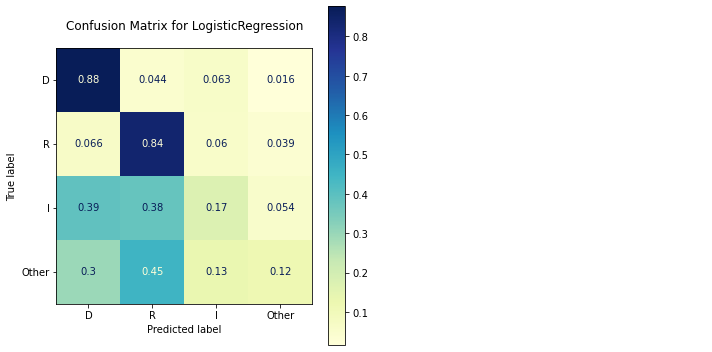

In [213]:
party_logreg = LogisticRegression(random_state=42, C=1000, solver="liblinear", class_weight="balanced")
party_logreg.fit(X_train, y_train)
evaluate_classifier(X_train, y_train, X_test, y_test, 
                    party_logreg, ["D", "R", "I", "Other"])

Clearly this mode is good at predicting Democrats and Republicans but fails to identify Independents and those who do not with any of those parties.  

### Random Forest 

Classification Report for RandomForestClassifier 

              precision    recall  f1-score   support

           D       0.70      0.92      0.80     14746
           R       0.64      0.88      0.74     11974
           I       0.52      0.16      0.25     10557
       Other       0.78      0.03      0.07      1926

    accuracy                           0.66     39203
   macro avg       0.66      0.50      0.46     39203
weighted avg       0.64      0.66      0.60     39203



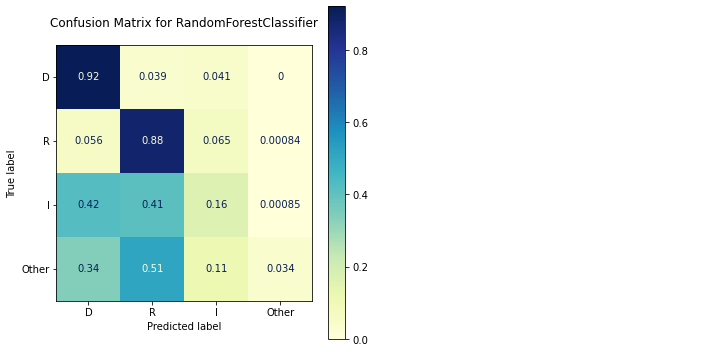

In [214]:
party_rf = RandomForestClassifier(random_state=42, class_weight="balanced")
party_rf.fit(X_train, y_train)
evaluate_classifier(X_train, y_train, X_test, y_test, 
                    party_rf, ["D", "R", "I", "Other"])

Once again our model only succeeds in predicting the two major parties. 

### XGBoost

Classification Report for XGBClassifier 

              precision    recall  f1-score   support

           D       0.71      0.90      0.80     14746
           R       0.65      0.85      0.74     11974
           I       0.49      0.22      0.30     10557
       Other       0.34      0.02      0.03      1926

    accuracy                           0.66     39203
   macro avg       0.55      0.50      0.47     39203
weighted avg       0.62      0.66      0.61     39203



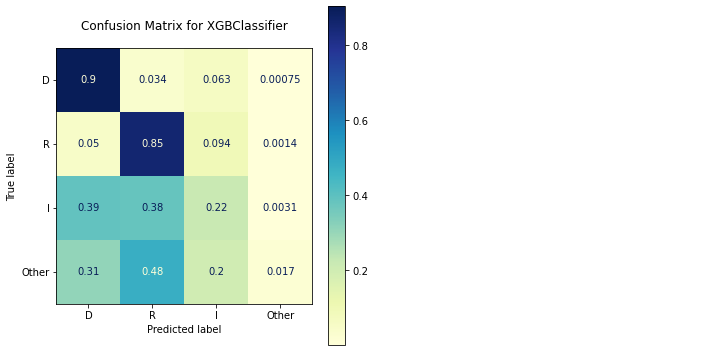

In [215]:
party_xg = xgb.XGBClassifier(random_state=42)
party_xg.fit(X_train, y_train)
evaluate_classifier(X_train, y_train, X_test, y_test, 
                    party_xg, ["D", "R", "I", "Other"])

Once again our model fails to accurately predict non-major parties. 

### Balancing the Training Data

While multiple grid searches were run to optimize the previous tree models, ultimately prediction rates for Independents and others remained less than chance. Therefore we can attempt to train the model on a more balanced training set, since the majority of our current sample consists of Democrats and Republicans.  

In [216]:
#We can see the severe class imbalance of this dataset
y_train.value_counts()

0    44350
1    36037
2    31396
3     5824
Name: pid3, dtype: int64

In [217]:
#Get the size of our smallest category
min_value = min(y_train.value_counts().values)
#Create a new dataframe with all of our training data
training_data = X_train.copy()
training_data["pid3"] = list(y_train.values)
training_data.head()

,totalvotes,Year,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon,% non-white,population,popdensity(sqkm),med household income,% unemployment,min wage,union density,Non-citizen,non-white,unemployment,% voted,% Change in totalvotes,% Change in Voting-Eligible Population (VEP),% Change in Voting-Age Population (VAP),% Change in Prison,% Change in Probation,% Change in Parole,% Change in Total Ineligible Felon,% Change in population,% Change in popdensity(sqkm),% Change in med household income,% Change in min wage,% Change in union density,% Change in Non-citizen,% Change in non-white,% Change in unemployment,birthyr,age,faminc,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,labor minwage abovefed_No,labor minwage abovefed_Yes,prez election year_No,prez election year_Yes,Post-Shelby_No,Post-Shelby_Yes,Covered by Shelby_No,Covered by Shelby_Some Counties,Covered by Shelby_State,anyid2_No,anyid2_Yes,absvot_No,...,"union hh_Yes, Formerly",employ_Full-Time,employ_Homemaker,employ_Missing,employ_Other,employ_Part-Time,employ_Permanently Disabled,employ_Retired,employ_Student,employ_Temporarily Laid Off,employ_Unemployed,no healthins_Missing,no healthins_No,no healthins_Yes,has child_Missing,has child_No,has child_Yes,ownhome_Missing,ownhome_Other,ownhome_Own,ownhome_Rent,no milstat_Missing,no milstat_No,no milstat_Yes,religion_Agnostic,religion_Atheist,religion_Buddhist,religion_Eastern or Greek Orthodox,religion_Hindu,religion_Jewish,religion_Missing,religion_Mormon,religion_Muslim,religion_Nothing in Particular,religion_Protestant,religion_Roman Catholic,religion_Something Else,economy retro_Gotten better / somewhat better,economy retro_Gotten much better,economy retro_Gotten much worse,economy retro_Gotten worse / somewhat worse,economy retro_Missing,economy retro_Not sure,economy retro_Stayed about the same,newsint_Don't Know,newsint_Hardly at all,newsint_Missing,newsint_Most of the time,newsint_Only now and then,newsint_Some of the time,approval pres_Approve / Somewhat Approve,approval pres_Disapprove / Somewhat Disapprove,approval pres_Missing,approval pres_Never Heard / Not Sure,approval pres_Strongly Approve,approval pres_Strongly Disapprove,approval rep_Approve / Somewhat Approve,approval rep_Disapprove / Somewhat Disapprove,approval rep_Missing,approval rep_Never Heard / Not Sure,approval rep_Never Heard of this Person,approval rep_Strongly Approve,approval rep_Strongly Disapprove,approval sen1_Approve / Somewhat Approve,approval sen1_Disapprove / Somewhat Disapprove,approval sen1_Missing,approval sen1_Never Heard / Not Sure,approval sen1_Never Heard of this Person,approval sen1_Strongly Approve,approval sen1_Strongly Disapprove,approval sen2_Approve / Somewhat Approve,approval sen2_Disapprove / Somewhat Disapprove,approval sen2_Missing,approval sen2_Never Heard / Not Sure,approval sen2_Never Heard of this Person,approval sen2_Strongly Approve,approval sen2_Strongly Disapprove,approval gov_Approve / Somewhat Approve,approval gov_Disapprove / Somewhat Disapprove,approval gov_Missing,approval gov_Never Heard / Not Sure,approval gov_Strongly Approve,approval gov_Strongly Disapprove,voted sen party_D,voted sen party_R,rep current_D,rep current_I,rep current_R,sen1 current_D,sen1 current_I,sen1 current_R,sen2 current_D,sen2 current_I,sen2 current_R,gov current_D,gov current_I,gov current_R,president_D,president_R,pid3
0,0.087964,-0.795168,0.608573,0.585498,0.930272,-0.075436,-0.607611,0.831739,-0.278993,0.334759,-0.065355,0.064977,-0.567717,0.967391,-0.343212,2.15

In [218]:
#Create a new dataframe with samples of each category equal to the size of our smallest class
balanced_training = pd.DataFrame()
for i in list(range(4)):
    undersample = training_data[training_data["pid3"]==i].sample(min_value)
    balanced_training = pd.concat([balanced_training, undersample])

#Now split the data back into X and y
y_train_balanced = balanced_training["pid3"].copy()
X_train_balanced = balanced_training.drop(columns=["pid3"]).copy()

#### Logistic Regression

Classification Report for LogisticRegression 

              precision    recall  f1-score   support

           D       0.72      0.82      0.76     14746
           R       0.66      0.74      0.69     11974
           I       0.45      0.18      0.25     10557
       Other       0.12      0.29      0.17      1926

    accuracy                           0.59     39203
   macro avg       0.49      0.51      0.47     39203
weighted avg       0.60      0.59      0.58     39203



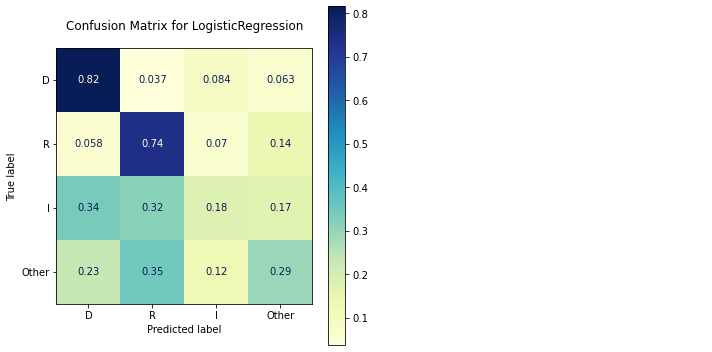

In [219]:
party_logreg_bal = LogisticRegression(random_state=42, C=1000, solver="liblinear")
party_logreg_bal.fit(X_train_balanced, y_train_balanced)
evaluate_classifier(X_train_balanced, y_train_balanced, X_test, y_test, 
                    party_logreg_bal, ["D", "R", "I", "Other"])

While our ability to predict the Other category improved, we are still unable to predict those identifying as Independents. 

#### Random Forest

Classification Report for RandomForestClassifier 

              precision    recall  f1-score   support

           D       0.72      0.82      0.77     14746
           R       0.65      0.68      0.66     11974
           I       0.40      0.19      0.26     10557
       Other       0.11      0.28      0.16      1926

    accuracy                           0.58     39203
   macro avg       0.47      0.49      0.46     39203
weighted avg       0.58      0.58      0.57     39203



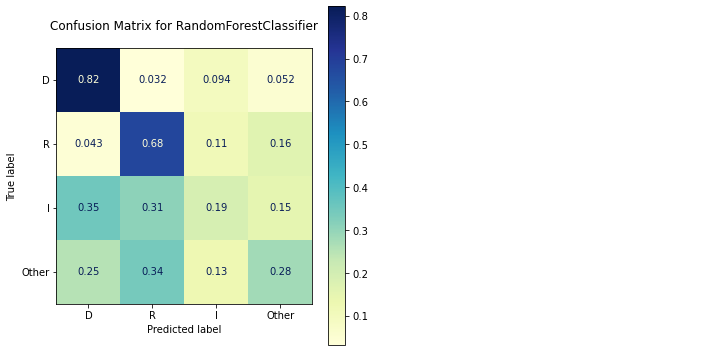

In [220]:
party_rf_bal = RandomForestClassifier(random_state=42)
party_rf_bal.fit(X_train_balanced, y_train_balanced)
evaluate_classifier(X_train_balanced, y_train_balanced, X_test, y_test, 
                    party_rf_bal, ["D", "R", "I", "Other"])

While this model again performs better than chance for the Other category it is deficient in its ability to predict Independents.  

#### XGBoost

Classification Report for XGBClassifier 

              precision    recall  f1-score   support

           D       0.74      0.77      0.75     14746
           R       0.67      0.67      0.67     11974
           I       0.40      0.23      0.30     10557
       Other       0.11      0.33      0.17      1926

    accuracy                           0.57     39203
   macro avg       0.48      0.50      0.47     39203
weighted avg       0.60      0.57      0.58     39203



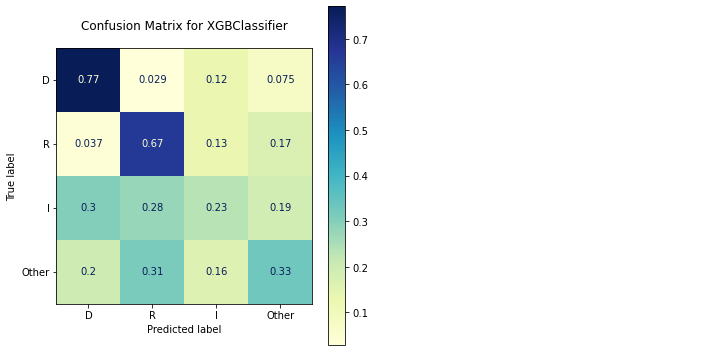

In [221]:
party_xg_bal = xgb.XGBClassifier(random_state=42)
party_xg_bal.fit(X_train_balanced, y_train_balanced)
evaluate_classifier(X_train_balanced, y_train_balanced, X_test, y_test, 
                    party_xg_bal, ["D", "R", "I", "Other"])

While this model performs best out of the three, it still does not predict Independents at a rate better than chance.  

Again, multiple grid searches were run to no avail. It is likely that this model is picking up on the liberal/conservative distinction rather than specifically what party someone chooses to officially align with.  

## Predict Party Voting

Next we can move onto a question with more actionable answers: what makes someone registered with a political party vote for or against that party in a senate race? 

We can create a column to track whether individuals voted for their stated political party in the senate race and attempt to predict it. 

In [222]:
major_parties = combined.copy()
#In this case we are only interested in people affiliated with the two major parties
major_parties = major_parties[(major_parties["pid3"]=="R") | (major_parties["pid3"]=="D")]

#New column that combines the party idenfication and senate vote
major_parties["Voting"] = major_parties["pid3"] + major_parties["voted sen party"]

#Right now, it is unclear which party is the identified party and which party is being voted for, so we
#rename the classes
major_parties["Voting"] = major_parties["Voting"].map({"DD": "D Voted D", "RR": "R Voted R", "RD": "R Voted D",
                                                       "DR": "D Voted R"})

major_parties.head()

,totalvotes,Year,State,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon,% non-white,population,popdensity(sqkm),med household income,% unemployment,min wage,labor minwage abovefed,prez election year,Post-Shelby,Covered by Shelby,anyid2,absvot,earlvot,elecdayreg,union density,wait,Non-citizen,non-white,unemployment,% voted,% Change in totalvotes,% Change in Voting-Eligible Population (VEP),% Change in Voting-Age Population (VAP),% Change in Prison,% Change in Probation,% Change in Parole,% Change in Total Ineligible Felon,% Change in population,% Change in popdensity(sqkm),% Change in med household income,% Change in min wage,% Change in union density,% Change in Non-citizen,% Change in non-white,% Change in unemployment,pid3,gender,birthyr,age,race,hispanic,citizen,educ,marstat,faminc,union,union hh,employ,no healthins,has child,ownhome,no milstat,religion,economy retro,newsint,approval pres,approval rep,approval sen1,approval sen2,approval gov,voted sen party,rep current,sen1 current,sen2 current,gov current,president,Voting
0,1526782,2006,AZ,3923786,4490327,0.126,35892,73265,6213,78738,0.391473,6103696.0,20.746264,52046.0,4.2,5.15,No,No,No,State,Yes,Yes,Yes,No,7.7,Not at all,769065.696,2.389431e+06,25635523.2,0.389109,-0.221696,0.055617,0.065142,0.13471,0.056559,0.095574,0.093978,0.070553,0.070553,-0.003084,0.0,0.222222,0.172954,0.113126,-0.118368,D,Female,1919,87,White,Missing,Citizen,2-Year,Married,15000,"No, Never","Yes, Currently",Retired,Missing,Missing,Own,No,Missing,Gotten worse / somewhat worse,Missing,Strongly Disapprove,Never Heard / Not Sure,Approve / Somewhat Approve,Approve / Somewhat Approve,Strongly Approve,D,D,R,R,D,R,D Voted D
1,1526782,2006,AZ,3923786,4490327,0.126,35892,73265,6213,78738,0.391473,6103696.0,20.746264,52046.0,4.2,5.15,No,No,No,State,Yes,Yes,Yes,No,7.7,Not at all,769065.696,2.389431e+06,25635523.2,0.389109,-0.221696,0.055617,0.065142,0.13471,0.056559,0.095574,0.093978,0.070553,0.070553,-0.003084,0.0,0.222222,0.172954,0.113126,-0.118368,D,Female,1921,85,White,Missing,Citizen,High School Graduate,Widowed,25000,"No, Never","No, Never",Retired,Missing,Missing,Own,No,Missing,Gotten much worse,Missing,Strongly Disapprove,Never Heard / Not Sure,Approve / Somewhat Approve,Disapprove / Somewhat Disapprove,Approve / Somewhat Approve,D,R,R,R,D,R,D Voted D
2,1526782,2006,AZ,3923786,4490327,0.126,35892,73265,6213,78738,0.391473,6103696.0,20.746264,52046.0,4.2,5.15,No,No,No,State,Yes,Yes,Yes,No,7.7,Not at all,769065.696,2.389431e+06,25635523.2,0.389109,-0.221696,0.055617,0.065142,0.13471,0.056559,0.095574,0.093978,0.070553,0.070553,-0.003084,0.0,0.222222,0.172954,0.113126,-0.118368,D,Female,1923,83,Mixed,Missing,Citizen,4-Year,Widowed,25000,"Yes, Formerly","No, Never",Retired,Missing,Missing,Own,Yes,Missing,Gotten much worse,Missing,Strongly Disapprove,Strongly Approve,Strongly Disapprove,Strongly Disapprove,Strongly Approve,D,D,R,R,D,R,D Voted D
3,1526782,2006,AZ,3923786,4490327,0.126,35892,73265,6213,78738,0.391473,6103696.0,20.746264,52046.0,4.2,5.15,No,No,No,State,Yes,Yes,Yes,No,7.7,Not at all,769065.696,2.389431e+06,25635523.2,0.389109,-0.221696,0.055617,0.065142,0.13471,0.056559,0.095574,0.093978,0.070553,0.070553,-0.003084,0.0,0.222222,0.172954,0.113126,-0.118368,D,Female,1925,81,Mixed,Missing,Citizen,High School Graduate,Married,35000,"Yes, Formerly","Yes, Formerly",Retired,Missing,Missing,Own,No,Missing,Stayed about the same,Missing,Strongly Disapprove,Strongly Approve,Strongly Disapprove,Strongly Disapprove,Strongly Approve,D,D,R,R,D,R,D Voted D
4,1526782,2006,AZ,3923786,4490327,0.126,35892,73265,6213,78738,0.391473,6103696.0,20.746264,52046.0,4.2,5.15,No,No,No,State,Yes,Yes,Yes,No,7.7,Not at all,769065.696,2.389431e+06,25635523.2,0.389109,-0.221696,0.055617,0.065142,0.13471,0.056559,0.095574,0.093978,0.070553,0.070553,-0.003084,0.0,0.222222,0.172954,0.113126,-0.118368,D,Female,1927,79,White,Missing,Citizen,2-Year,Widowed,650

In [223]:
#Split the data
X_train, X_test, y_train, y_test = create_x_and_y(major_parties, outcome="Voting", random_state=21, 
                                                  cols_to_drop=["voted sen party"],
                                                  y_map={"D Voted D": 0, "R Voted R": 1, 
                                                         "R Voted D":2, "D Voted R": 3})

### Logistic Regression

Classification Report for LogisticRegression 

              precision    recall  f1-score   support

   D Voted D       0.96      0.96      0.96     14011
   R Voted R       0.95      0.95      0.95     10840
   R Voted D       0.55      0.55      0.55      1129
   D Voted R       0.32      0.37      0.35       797

    accuracy                           0.92     26777
   macro avg       0.70      0.71      0.70     26777
weighted avg       0.92      0.92      0.92     26777



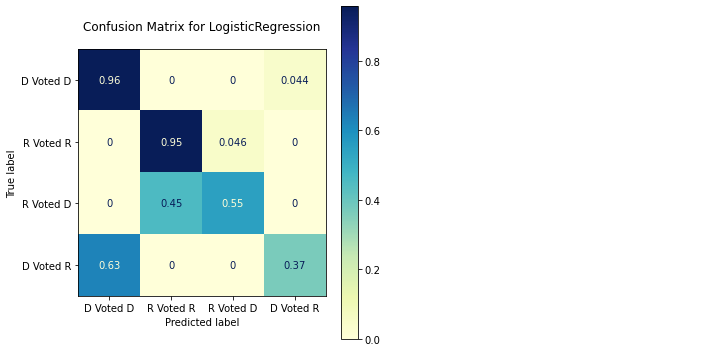

In [224]:
pred_party_logreg = LogisticRegression(random_state=42, C=1000, solver="liblinear", class_weight="balanced")
pred_party_logreg.fit(X_train, y_train)
evaluate_classifier(X_train, y_train, X_test, y_test, 
                    pred_party_logreg, ["D Voted D", "R Voted R", "R Voted D", "D Voted R"])

While this model does better than chance, it still overpredicts individuals voting with their registered party, the more common occurrence. Therefore we can move on to our next model. 

### Random Forest

Classification Report for RandomForestClassifier 

              precision    recall  f1-score   support

   D Voted D       0.95      1.00      0.98     14011
   R Voted R       0.94      1.00      0.97     10840
   R Voted D       0.94      0.42      0.58      1129
   D Voted R       0.88      0.17      0.28       797

    accuracy                           0.95     26777
   macro avg       0.93      0.65      0.70     26777
weighted avg       0.95      0.95      0.94     26777



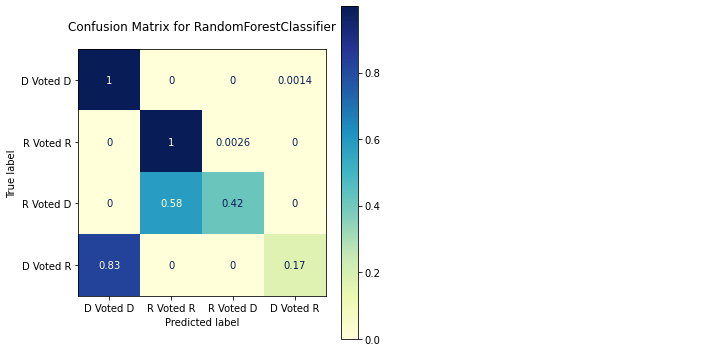

In [225]:
pred_party_rf = RandomForestClassifier(random_state=42, class_weight="balanced")
pred_party_rf.fit(X_train, y_train)
evaluate_classifier(X_train, y_train, X_test, y_test, 
                    pred_party_rf, ["D Voted D", "R Voted R", "R Voted D", "D Voted R"])

This model performs even worse, so we can move onto our next model.

### XGBoost

Classification Report for XGBClassifier 

              precision    recall  f1-score   support

   D Voted D       0.96      0.99      0.98     14011
   R Voted R       0.96      0.99      0.97     10840
   R Voted D       0.81      0.57      0.67      1129
   D Voted R       0.72      0.36      0.48       797

    accuracy                           0.95     26777
   macro avg       0.86      0.73      0.77     26777
weighted avg       0.95      0.95      0.95     26777



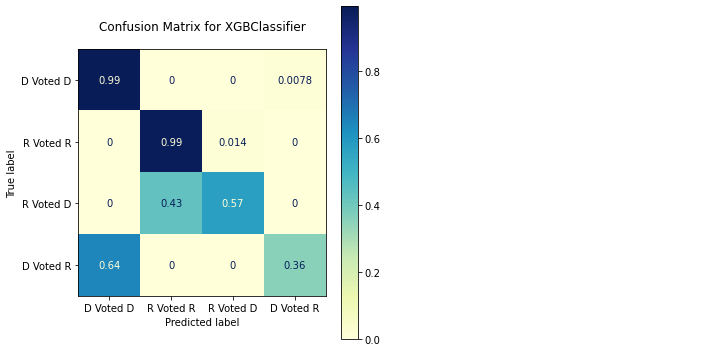

In [226]:
pred_party_xg = xgb.XGBClassifier(random_state=42)
pred_party_xg.fit(X_train, y_train)
evaluate_classifier(X_train, y_train, X_test, y_test, 
                    pred_party_xg, ["D Voted D", "R Voted R", "R Voted D", "D Voted R"])

Again the model performs poorly, though better than chance. We can attempt to optimize the results via grid search.

### Grid Search

We ran the following grid search, using balanced accuracy scoring to reflect our desire to optimize our ability to predict all classes. 
```
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [5, 10, 15, 20],
              "min_samples_leaf": [1, 5, 10, 20],
              "class_weight": ["balanced", {0:1, 1:1, 2:2, 3:2}, {0:1, 1:1, 2:3, 3:2}, 
                                {0:1, 1:1, 2:2, 3:3}, {0:1, 1:1, 2:3, 3:3}]}
gridsearch = GridSearchCV(pred_party_rf, param_grid=param_grid, cv=5, scoring="balanced_accuracy")
gridsearch.fit(X_train, y_train)
gridsearch.best_params_ 
```

Classification Report for RandomForestClassifier 

              precision    recall  f1-score   support

   D Voted D       0.98      0.93      0.96     14011
   R Voted R       0.97      0.93      0.95     10840
   R Voted D       0.53      0.77      0.63      1129
   D Voted R       0.37      0.72      0.49       797

    accuracy                           0.92     26777
   macro avg       0.71      0.84      0.76     26777
weighted avg       0.94      0.92      0.93     26777



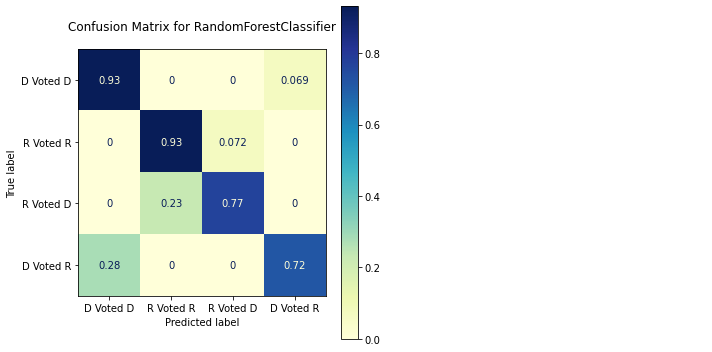

In [227]:
pred_party_best_rf = RandomForestClassifier(random_state=42, class_weight="balanced", criterion="entropy", 
                                            min_samples_leaf=20, min_samples_split=5)
pred_party_best_rf.fit(X_train, y_train)
evaluate_classifier(X_train, y_train, X_test, y_test, 
                    pred_party_best_rf, ["D Voted D", "R Voted R", "R Voted D", "D Voted R"])

This model maintains our ability to correctly predict own-party voting but increases our ability to predict opposite party voting. Therefore we can investigate the feature importances to indicate the important factors in voting decisions.    

### Feature Importances

We will find the model's top 15 most influential factors in classifying opposite party voting. Then we will examine each factor and its important dimensions.    

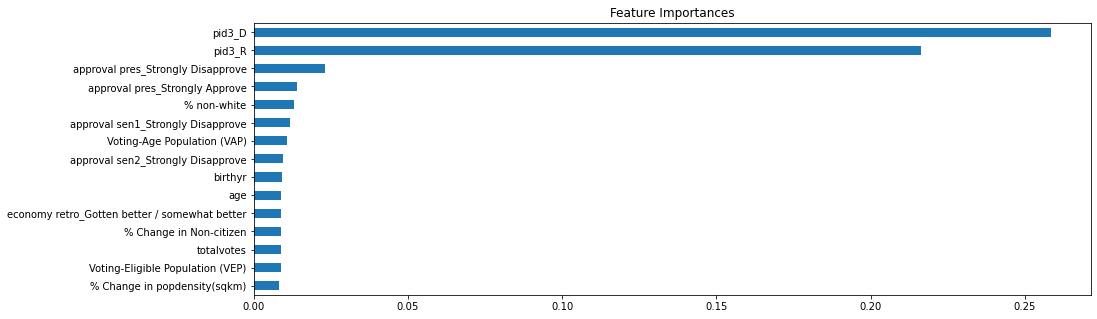

In [228]:
important_features_mp, feature_cols_mp = get_feature_importances(pred_party_best_rf, X_train)

#### Political Party Identification

Important Aspects of pid3 are:
- D
- R


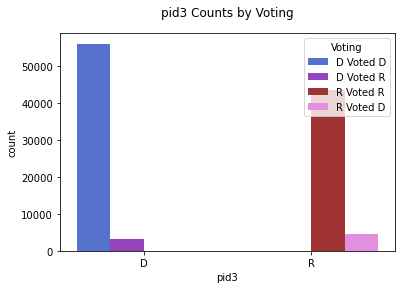

In [297]:
#Create a color palette that has each party associated with its correct color
palette_mp={"D Voted D": "royalblue", "D Voted R": "darkorchid", "R Voted R": "firebrick", "R Voted D": "violet"}
feature_plots(major_parties, feature_cols_mp[0], "Voting", important_features_mp, palette=palette_mp, orient="v")

As one would expect, most people vote with the party they are registered with. While this does not give us any new information, it makes sense that the model would pick up on this.  

#### Presidential Approval

Important Aspects of approval pres are:
- Strongly Disapprove
- Strongly Approve


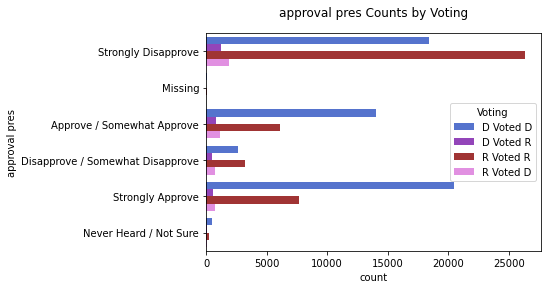

In [298]:
feature_plots(major_parties, feature_cols_mp[1], "Voting", important_features_mp, palette=palette_mp)

This relationship will likely become clearer if we add in the context of the president's party. 

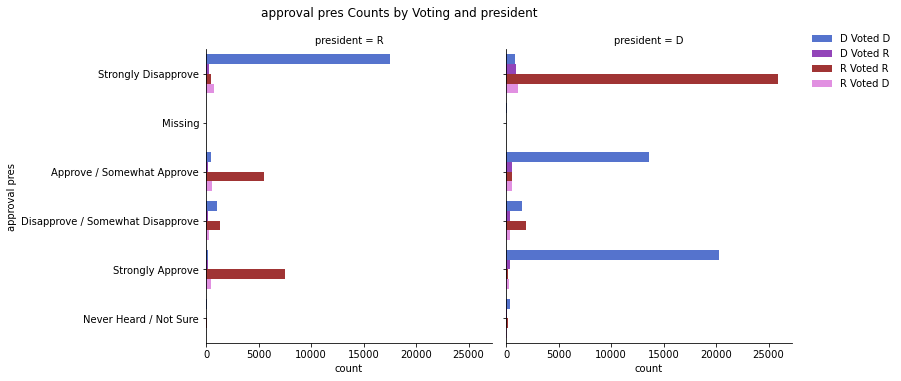

In [301]:
clarifying_plots(major_parties, feature_cols_mp[1], "Voting", "president", palette=palette_mp)

- As expected, when voters strongly approve of the president who shares their party or strongly disapprove of the president who does not, they tend to vote with their party. This indicates the importance of national politics on Senate races.
- Republicans voting for a Democratic senator was most common when they strongly disapproved of a Republican president. 

#### Non-White Population Percentage

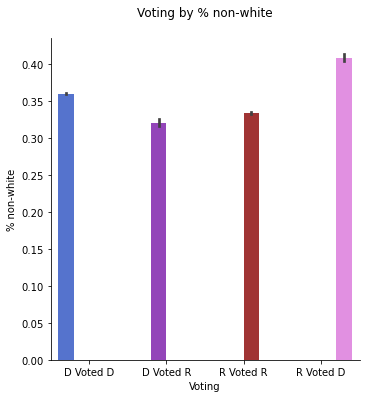

In [302]:
feature_plots(major_parties, feature_cols_mp[2], "Voting", important_features_mp, palette=palette_mp)

- Republicans voting Democratic is associated with a high percentage of the population in their state being non-white. 
- This followed by Democrats who vote with their party, Republicans who vote with their party, and lastly Democrats who vote Republican. 
- Overall the conventional wisdom that racial diversity is associated with more liberal attitudes does seem to be supported. 

#### Voting-Age Population, Voting Eligible Population, and Total Votes

The voting-age and voting-eligible population, as well as total votes, have very similar results and seem to be capturing the same phenomena so we will draw conclusions from all three. 

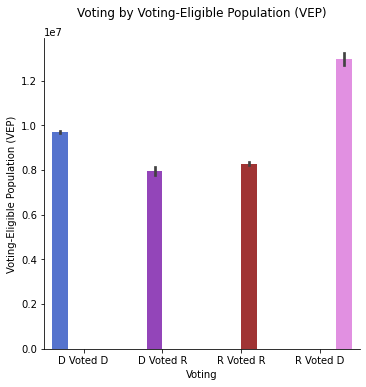

In [233]:
feature_plots(major_parties, feature_cols_mp[11], "Voting", important_features_mp, palette=palette_mp)

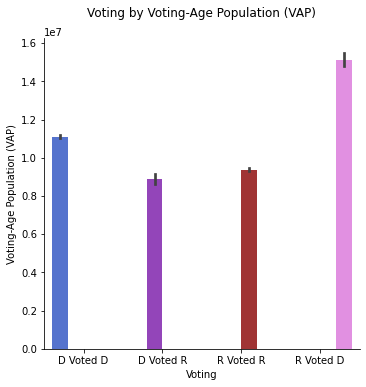

In [234]:
feature_plots(major_parties, feature_cols_mp[4], "Voting", important_features_mp, palette=palette_mp)

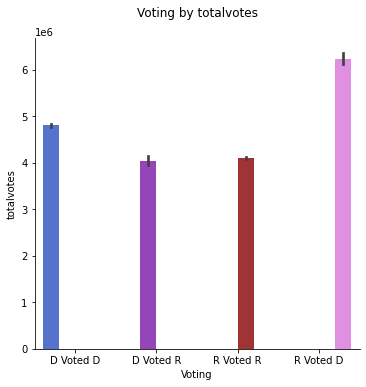

In [235]:
feature_plots(major_parties, feature_cols_mp[10], "Voting", important_features_mp, palette=palette_mp)

- Voting for Democrats as a Republican is associated with a larger population, in terms of people of voting age, people who can actually vote, and who actually cast votes. 
- Voting for Democrats as a Democrat is also associated with a larger population.

#### Senator Approval

Approval for both senators were noted as important features, so we can look at both of them together. 

Important Aspects of approval sen1 are:
- Strongly Disapprove


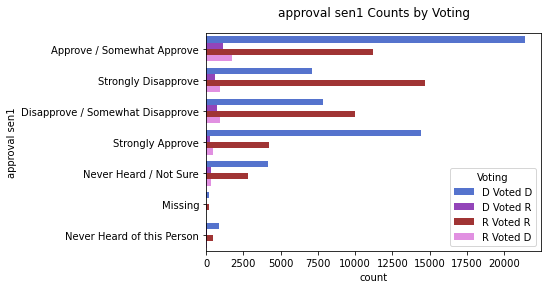

In [304]:
feature_plots(major_parties, feature_cols_mp[3], "Voting", important_features_mp, palette=palette_mp, orient="h")

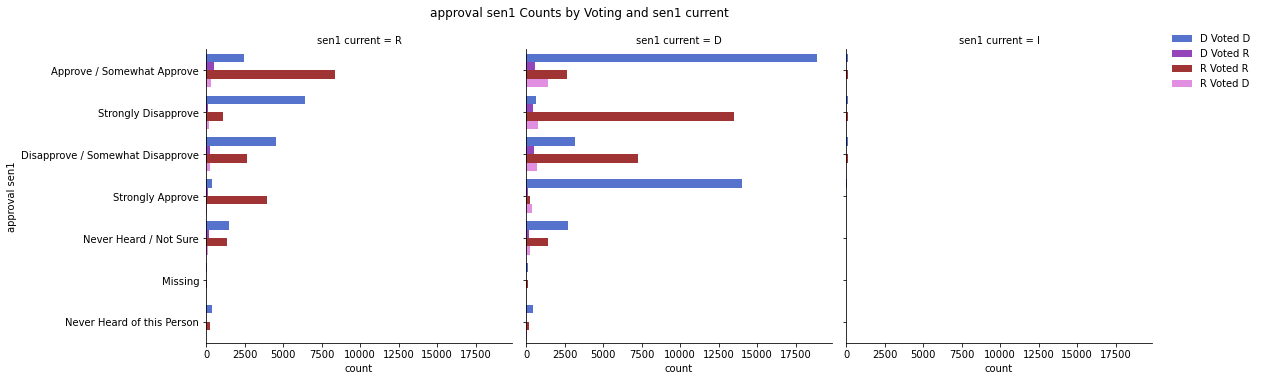

In [305]:
clarifying_plots(major_parties, feature_cols_mp[3], "Voting", "sen1 current", palette=palette_mp, orient="h")

Important Aspects of approval sen2 are:
- Strongly Disapprove


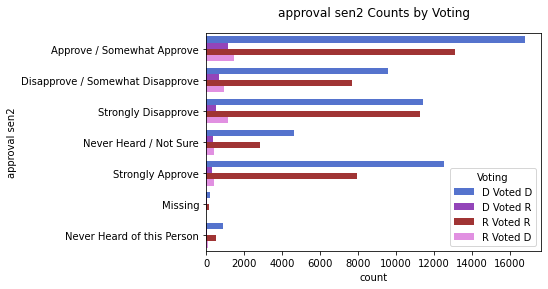

In [306]:
feature_plots(major_parties, feature_cols_mp[5], "Voting", important_features_mp, palette=palette_mp, orient="h")

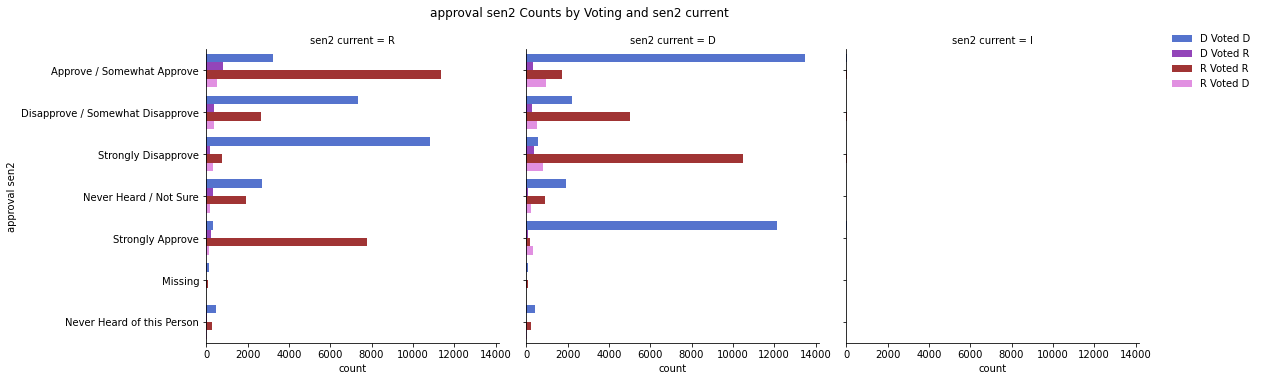

In [307]:
clarifying_plots(major_parties, feature_cols_mp[5], "Voting", "sen2 current", palette=palette_mp, orient="h")

- Much like approval of the president, strongly disapproving of your opposite party senator is related to voting with your own party. 
- However this does not seem to extend to opposite party voting, where Republicans are still fairly likely to vote for a Democrat when they strongly disapprove of their Democratic senator.  
- Democrats are unlikely to vote Republican when they strongly disapprove of their Republican senator. 

#### Change in Population Density

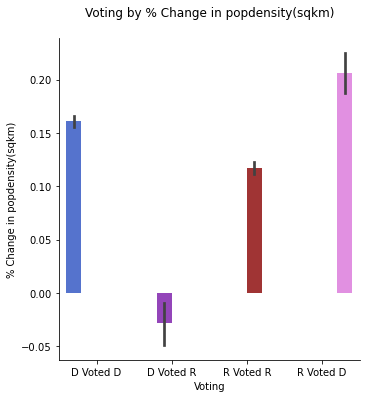

In [240]:
feature_plots(major_parties, feature_cols_mp[12], "Voting", important_features_mp, palette=palette_mp)

- For both self-identified Democrats and Republicans, living in a place that is increasingly dense is associated with voting for Democrats. 
- While Republicans who vote for Republicans also live in places that are on average growing denser - although to a lesser degree - Democrats who vote for Republicans are the only group that are more likely to live in places becoming less dense.  

#### Age

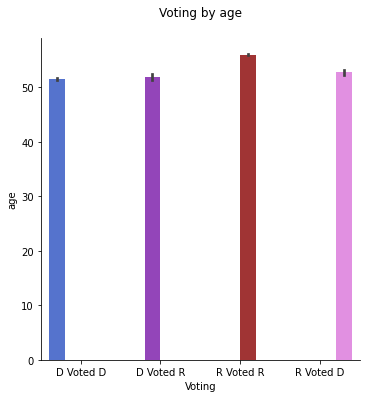

In [241]:
feature_plots(major_parties, feature_cols_mp[7], "Voting", important_features_mp, palette=palette_mp)

- While Republicans who vote with their party are the oldest, the other groups are fairly similar in age. 

#### Economy

Important Aspects of economy retro are:
- Gotten better / somewhat better


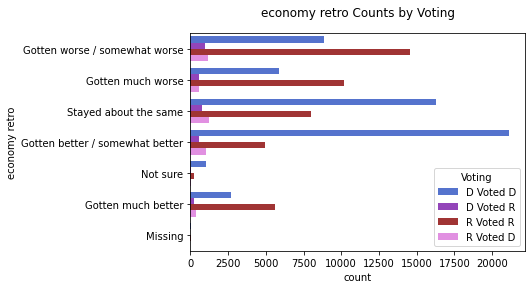

In [308]:
feature_plots(major_parties, feature_cols_mp[8], "Voting", important_features_mp, palette=palette_mp, orient="h")

It is possible the party of the president is related to a person's views on the economy and their voting choice so we can break down the visuals in this way.

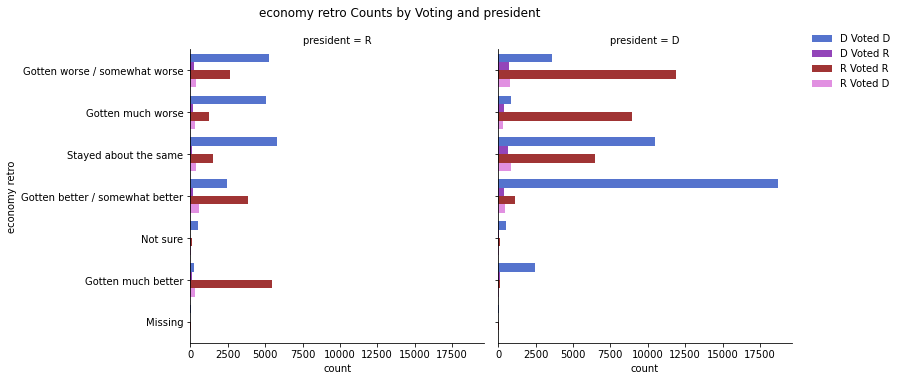

In [309]:
clarifying_plots(major_parties, feature_cols_mp[8], "Voting", "president", palette=palette_mp, orient="h")

- Feelings about whether or not the economy has improved seem to relate to who is in charge with Democrats who voted for a Democratic senator being more likely to believe the has gotten better under a Democratic president. 
- Most of this survey was conducted when a Democrat was president so this might impact the results. 

#### Birth Year

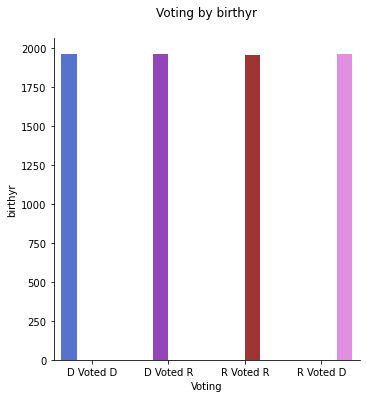

In [244]:
feature_plots(major_parties, feature_cols_mp[6], "Voting", important_features_mp, palette=palette_mp)

This does not provide us with much information. It is possible that Republicans who vote for Democrats are younger but it is difficult to tell. 

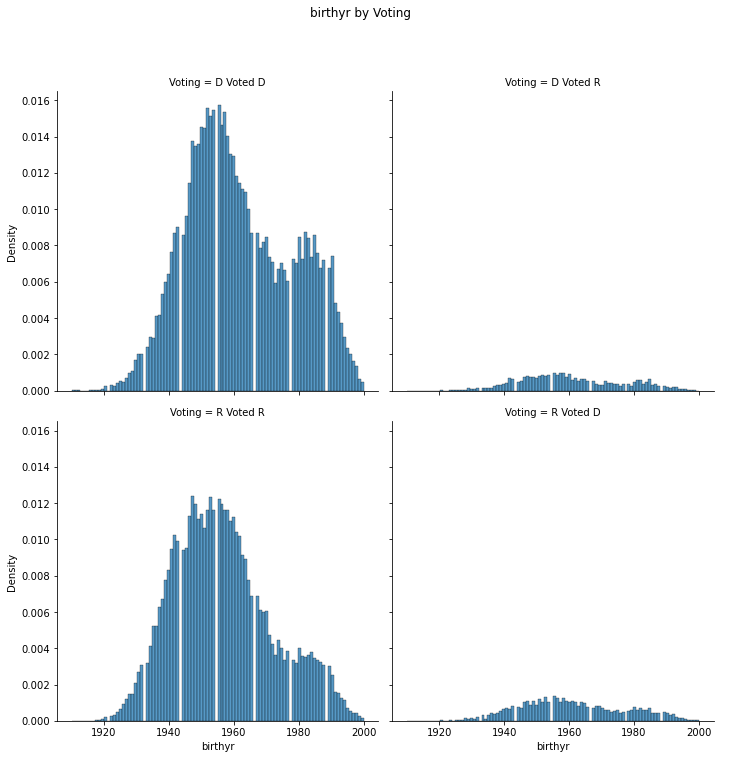

In [245]:
clarifying_plots(major_parties, feature_cols_mp[6], "Voting")

This is still not informative so we can try a box plot.

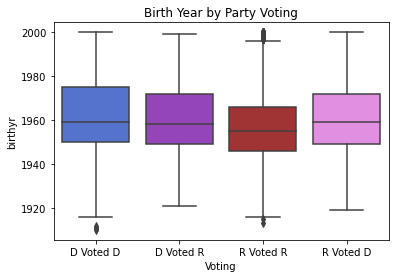

In [246]:
sns.boxplot(x="Voting", data=major_parties, y=feature_cols_mp[6], palette=palette_mp);
plt.title("Birth Year by Party Voting");

- We can see the same pattern as when we looked at age.
- Those who voted against their party are most similar in birth year where Republicans who vote with their party tend towards more distant birth years while all other tend towards slightly more recent birth years.    

#### Percent Change in Non-Citizen Population

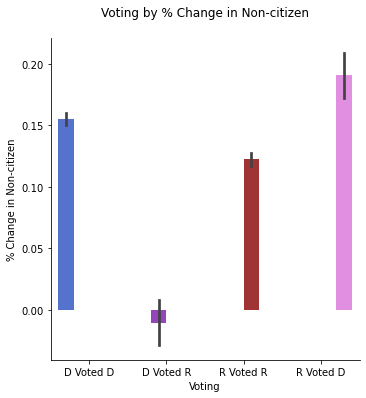

In [247]:
feature_plots(major_parties, feature_cols_mp[9], "Voting", important_features_mp, palette=palette_mp)

- Republicans who vote for Democrats on average live in the places with the largest increase in non-citizen population followed by Democrats who vote for Democrats and Republicans who vote for Republicans.
- Democrats who vote for Republicans are the only group that on average live in places with a decreasing non-citizen population. 

### Conclusion

- We can predict which party majority-party identified individuals vote for with 92% accuracy using our model.
- However we only predict individuals who do not vote with their party over 70% of the time.
- Party is the biggest indication of voting preference, with the majority of people voting for their registered party.
- Approval of current elected officials, and specifically a person's view on whether the economy has approved, does influence voting so not everyone is simply voting on the party line.
- Being older is related to being a Republican who votes Republican.
- Overall larger populations who can and do vote, living in a state getting more dense, living in a state with a higher percent of non-white individuals, and living in a state with an increasing non-citizen population are associated with Republicans who vote for Democrats.
- On the other hand, Democrats who vote for Republicans on average live in states with the smallest percentage of non-white individuals and states where density and non-citizen populations are decreasing. 

## Predict Those Who Voted Against Their Party

Now we can expand our previous question to include the majority of people who do vote with their party: those unaffiliated with either major party. These swing voters are often crucial to winning elections and it is important to know what factors are predictive of their vote choice.    

In [248]:
unaffiliated = combined.copy()
#Now we want all cases where someone did not vote with their party identification
unaffiliated = unaffiliated[(unaffiliated["pid3"]!="R") & (unaffiliated["pid3"]!="D")]

#Split the data
X_train, X_test, y_train, y_test = create_x_and_y(unaffiliated, outcome="voted sen party", random_state=7,  
                                                  y_map={"D": 0, "R": 1})

### Logistic Regression

Classification Report for LogisticRegression 

              precision    recall  f1-score   support

           D       0.78      0.76      0.77      6139
           R       0.77      0.79      0.78      6287

    accuracy                           0.77     12426
   macro avg       0.77      0.77      0.77     12426
weighted avg       0.77      0.77      0.77     12426



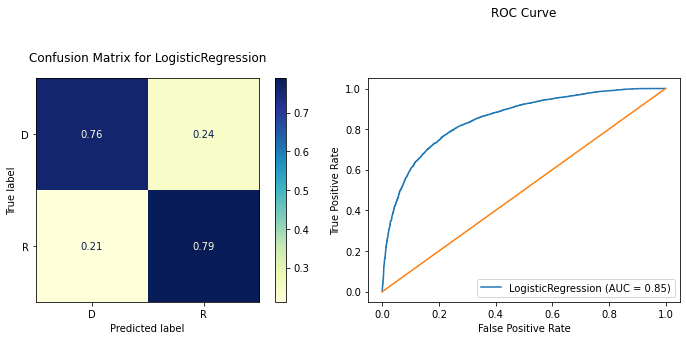

In [249]:
unaffiliated_logreg = LogisticRegression(C=1000, solver="liblinear", random_state=42)
unaffiliated_logreg.fit(X_train, y_train)
evaluate_classifier(X_train, y_train, X_test, y_test, 
                    unaffiliated_logreg, ["D", "R"])

### Random Forest

Classification Report for RandomForestClassifier 

              precision    recall  f1-score   support

           D       0.90      0.90      0.90      6139
           R       0.91      0.91      0.91      6287

    accuracy                           0.90     12426
   macro avg       0.90      0.90      0.90     12426
weighted avg       0.90      0.90      0.90     12426



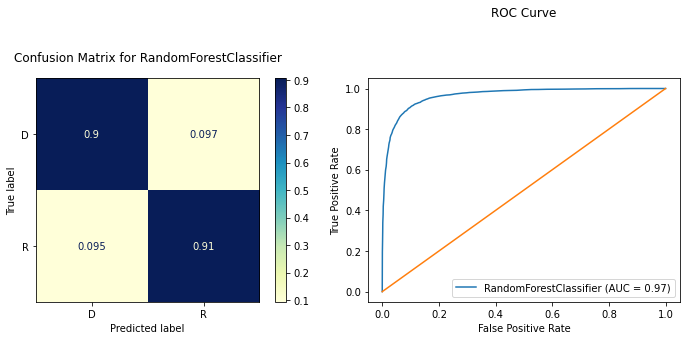

In [250]:
unaffiliated_rf = RandomForestClassifier(random_state=42)
unaffiliated_rf.fit(X_train, y_train)
evaluate_classifier(X_train, y_train, X_test, y_test, 
                    unaffiliated_rf, ["D", "R"])

### XGBoost

Classification Report for XGBClassifier 

              precision    recall  f1-score   support

           D       0.90      0.90      0.90      6139
           R       0.90      0.91      0.90      6287

    accuracy                           0.90     12426
   macro avg       0.90      0.90      0.90     12426
weighted avg       0.90      0.90      0.90     12426



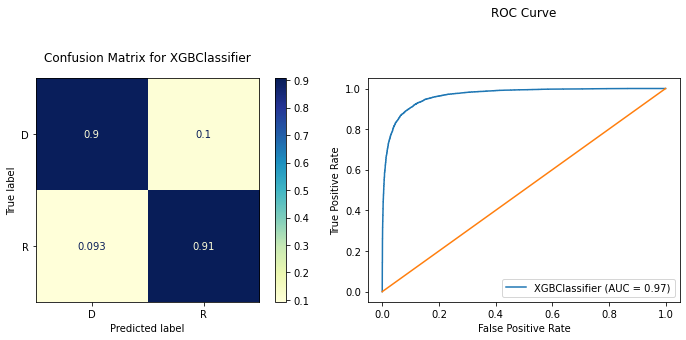

In [251]:
unaffiliated_xg = xgb.XGBClassifier(random_state=42)
unaffiliated_xg.fit(X_train, y_train)
evaluate_classifier(X_train, y_train, X_test, y_test, 
                    unaffiliated_xg, ["D", "R"])

### Grid Search

#### Random Forest

We ran the following grid search to optimize our random forest. 
```
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [5, 10, 15, 20],
              "min_samples_leaf": [1, 5, 10, 20]}
gridsearch = GridSearchCV(against_party_rf, param_grid=param_grid, cv=5, scoring="f1")
gridsearch.fit(X_train, y_train)
gridsearch.best_params_ 
```

Classification Report for RandomForestClassifier 

              precision    recall  f1-score   support

           D       0.90      0.90      0.90      6139
           R       0.91      0.91      0.91      6287

    accuracy                           0.91     12426
   macro avg       0.91      0.91      0.91     12426
weighted avg       0.91      0.91      0.91     12426



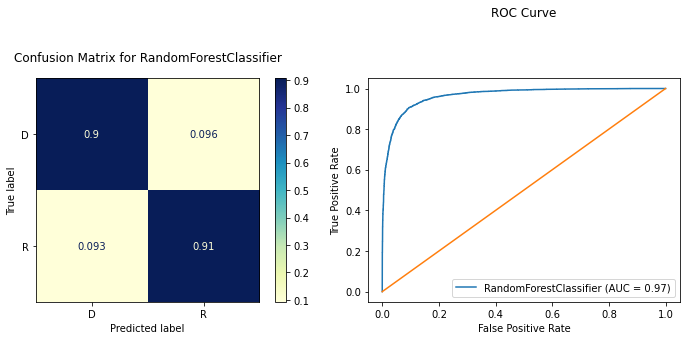

In [252]:
unaffiliated_best_rf = RandomForestClassifier(random_state=42, criterion="entropy", min_samples_leaf=1, 
                                               min_samples_split=20)
unaffiliated_best_rf.fit(X_train, y_train)
evaluate_classifier(X_train, y_train, X_test, y_test, 
                    unaffiliated_best_rf, ["D", "R"])

This model performs very well across all metrics but we can explore the more computationally expensive models to see if we can make a significant improvement. 

#### XGBoost

We ran the following grid search to optimize our XGBoost mmodeldeol. 
```
param_grid = {"learning_rate": [.05, .1, .2],
              "max_depth": [3, 6],
              "min_child_weight": [1, 3, 5],
              "subsample": [.5, .8, 1]}
gridsearch = GridSearchCV(unaffiliated_xg, param_grid=param_grid, cv=5, scoring="f1")
gridsearch.fit(X_train, y_train)
gridsearch.best_params_
```

Classification Report for XGBClassifier 

              precision    recall  f1-score   support

           D       0.91      0.90      0.90      6139
           R       0.90      0.91      0.91      6287

    accuracy                           0.90     12426
   macro avg       0.91      0.90      0.90     12426
weighted avg       0.91      0.90      0.90     12426



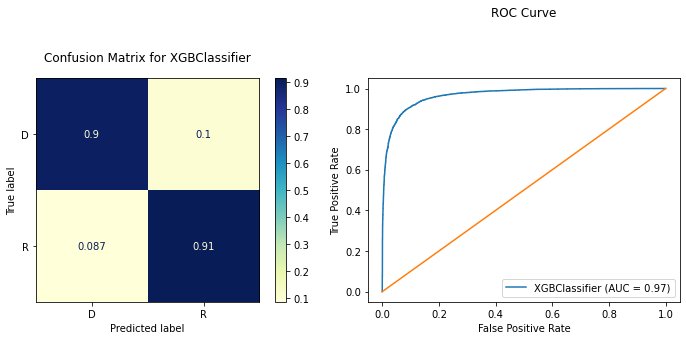

In [253]:
unaffiliated_best_xg = xgb.XGBClassifier(random_state=42, learning_rate=.2, max_depth=6, min_child_weight=5, 
                                          subsample=.8)
unaffiliated_best_xg.fit(X_train, y_train)
evaluate_classifier(X_train, y_train, X_test, y_test, 
                    unaffiliated_best_xg, ["D", "R"])

Of the two, the random forest model is 1% more accurate and less resource intensive. 

## Voting Classifier

Since we have multiple strong models, we can see if the combination is better than any of the models alone. 

Classification Report for VotingClassifier 

              precision    recall  f1-score   support

           D       0.90      0.90      0.90      6139
           R       0.90      0.90      0.90      6287

    accuracy                           0.90     12426
   macro avg       0.90      0.90      0.90     12426
weighted avg       0.90      0.90      0.90     12426



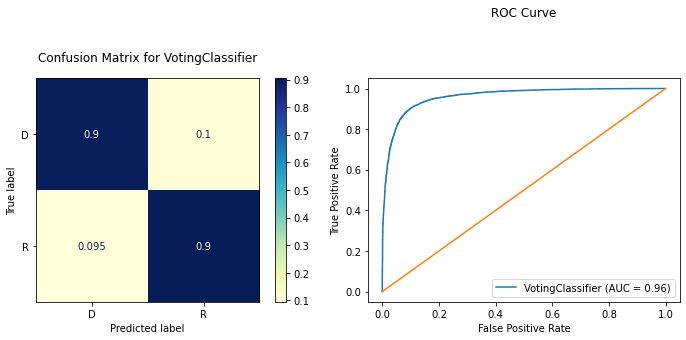

In [254]:
unaffiliated_vc = VotingClassifier(estimators=[("lr", unaffiliated_logreg), 
                                                ("rf", unaffiliated_best_rf), 
                                                ("xg", unaffiliated_best_xg)], voting="soft")
unaffiliated_vc.fit(X_train, y_train)
evaluate_classifier(X_train, y_train, X_test, y_test, 
                    unaffiliated_vc, ["D", "R"])

Given that the random forest model runs more quickly and yields almost exactly the same results, we will use it as our final model.

## Feature Importances

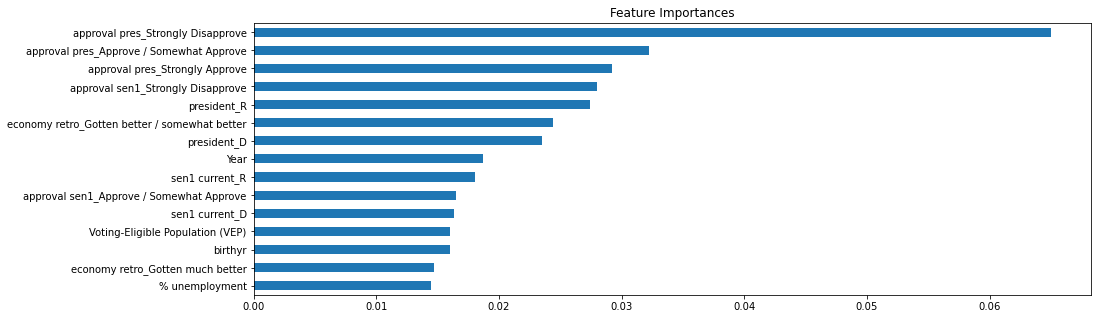

In [255]:
important_features_u, feature_cols_u = get_feature_importances(unaffiliated_best_rf, X_train)

#### Presidential Approval 

Important Aspects of approval pres are:
- Strongly Disapprove
- Approve / Somewhat Approve
- Strongly Approve


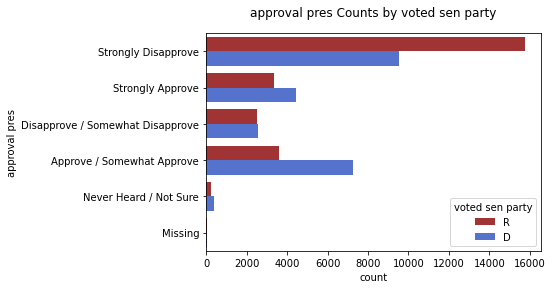

In [310]:
#Create a color palette that has each party associated with its correct color
palette_u={"D": "royalblue", "R": "firebrick"}
feature_plots(unaffiliated, feature_cols_u[0], "voted sen party", important_features_u, palette=palette_u, orient="h")

Looking at the context of presidential party will clarify why this is important. 

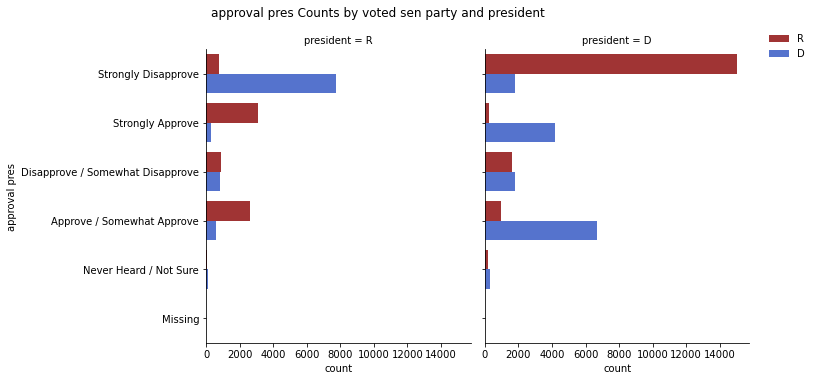

In [311]:
clarifying_plots(unaffiliated, feature_cols_u[0], "voted sen party", "president", palette=palette_u, orient="h")

- As expected when someone strongly disapproves of a president, they are less likely to vote for a senator of that same party. 
- Likewise is if they approve of the president, they are more likely to vote for a senator of that party. 

Important Aspects of president are:
- R
- D


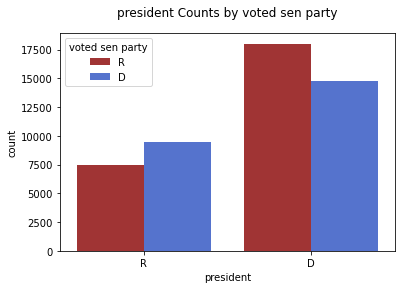

In [258]:
feature_plots(unaffiliated, feature_cols_u[2], "voted sen party", important_features_u, palette=palette_u)

- In general swing voters seem to vote for the candidate of whichever party is not in power, though not by a very large margin. 
- Thus this is not the only explanation behind swing voters' behavior. 

#### Senator Approval

Important Aspects of sen1 current are:
- R
- D


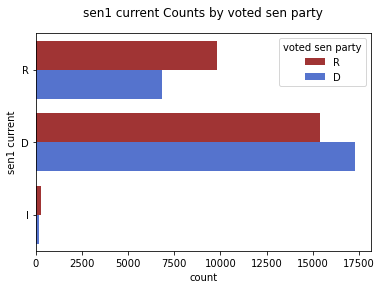

In [312]:
feature_plots(unaffiliated, feature_cols_u[5], "voted sen party", important_features_u, palette=palette_u, orient="h")

- It appears that voters who do not vote with their party tend to vote for a senator who is the opposite party of the current senator, similar to the president.   
- Clearly most of the people surveyed have a Democratic senator, perhaps pointing to a flaw in the representativeness of this survey. 
- When we look at approval, this relationship might become more clear.

Important Aspects of approval sen1 are:
- Strongly Disapprove
- Approve / Somewhat Approve


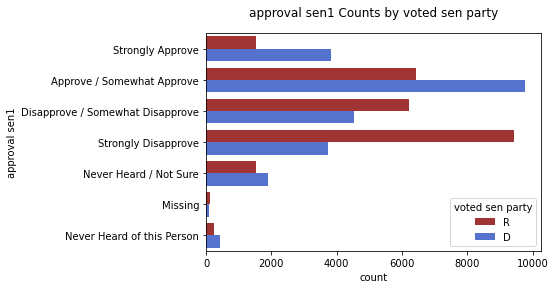

In [313]:
feature_plots(unaffiliated, feature_cols_u[1], "voted sen party", important_features_u, palette=palette_u, orient="h")

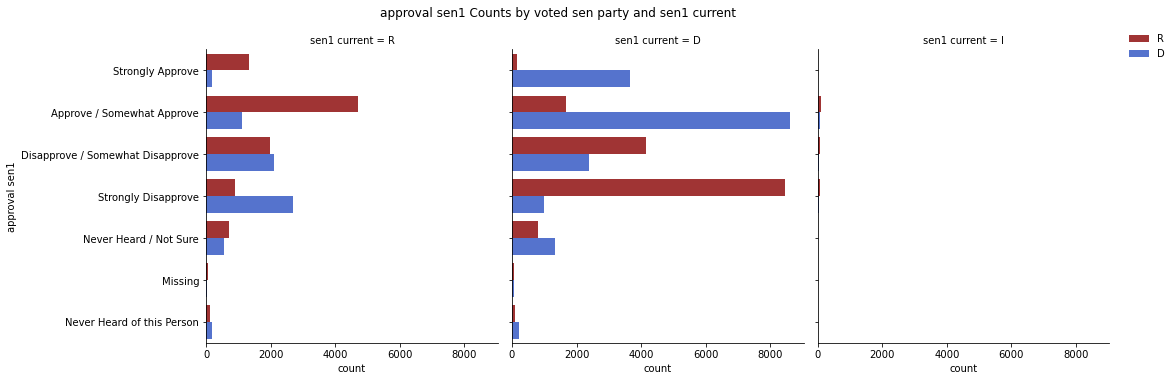

In [314]:
clarifying_plots(unaffiliated, feature_cols_u[1], "voted sen party", "sen1 current", palette=palette_u, orient="h")

- As would be assumed, approving of a senator is associated with voting for a candidate of their party and strongly disapproving of a senator is associated with voting for a candidate of the opposite party. 

#### Birth Year

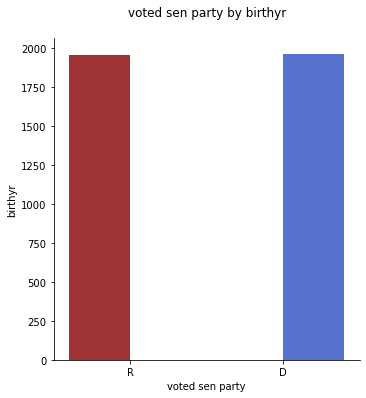

In [262]:
feature_plots(unaffiliated, feature_cols_u[7], "voted sen party", important_features_u, palette=palette_u)

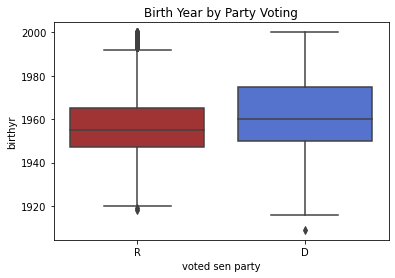

In [263]:
sns.boxplot(x="voted sen party", data=unaffiliated, y=feature_cols_u[7], palette=palette_u);
plt.title("Birth Year by Party Voting");

- Major-party-unaffiliated voters who voted for Democratic senators tend to have been born later and the majority are in a younger but broader age range.

#### Economy

Important Aspects of economy retro are:
- Gotten better / somewhat better
- Gotten much better


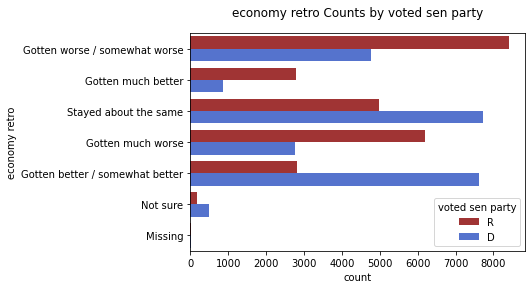

In [315]:
feature_plots(unaffiliated, feature_cols_u[3], "voted sen party", important_features_u, palette=palette_u, orient="h")

- When the economy is perceived to have gotten somewhat better, Democratic Senate candidates seem to hold an advantage but when the economy is perceived to have gotten much better, Republicans enjoy an advantage.
- Look at the results split by both senators, president, and governor party still show the same results.
- This factor must have some underlying cause but nothing in this dataset seems to provide an explanation.

#### Unemployment

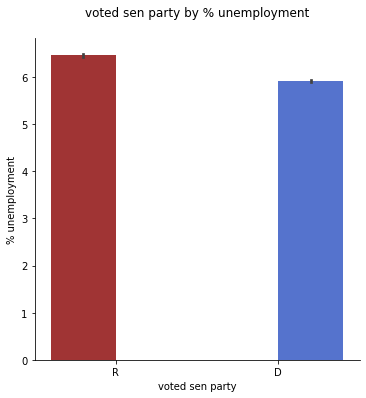

In [265]:
feature_plots(unaffiliated, feature_cols_u[8], "voted sen party", important_features_u, palette=palette_u)

- It appears that higher unemployment gives an advantage to Republican candidates but we can examine this in more detail. 

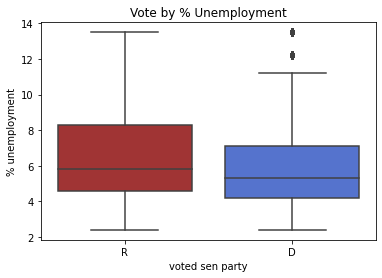

In [266]:
sns.boxplot(x="voted sen party", data=unaffiliated, y=feature_cols_u[8], palette=palette_u);
plt.title("Vote by % Unemployment");

- It does appear that more swing voters choose a Republican candidate when unemployment is higher.  

#### Year

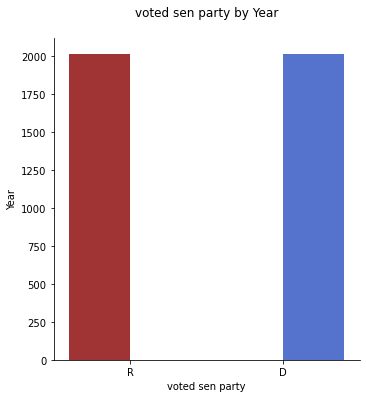

In [267]:
feature_plots(unaffiliated, feature_cols_u[4], "voted sen party", important_features_u, palette=palette_u)

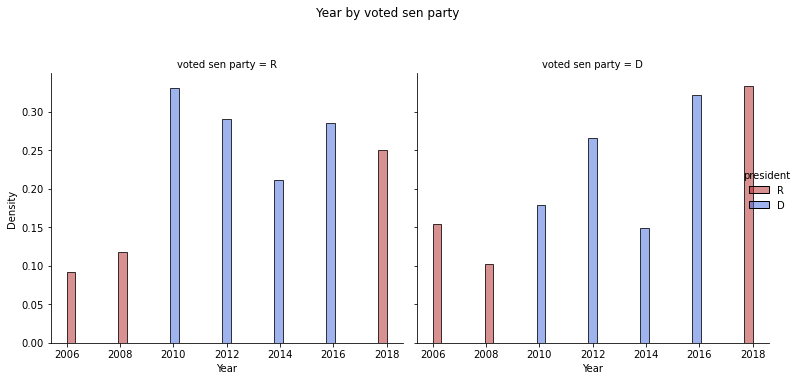

In [268]:
clarifying_plots(unaffiliated, feature_cols_u[4], "voted sen party", "president", palette=palette_u)

- The first senate election after a presidential (i.e. midterms), appears to give the opposite party an advantage.
- Otherwise it appears other factors might provide better insight. 

#### Voting-Eligible Population

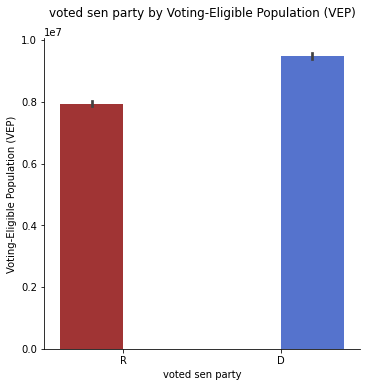

In [269]:
feature_plots(unaffiliated, feature_cols_u[6], "voted sen party", important_features_u, palette=palette_u)

- The more voting-eligible people in someone's state, the more likely they are to vote for a Democrat.  

### Conclusion

- We can predict which party non-majority-party identified individuals vote for with 91% accuracy using our model.
- Swing voters who voted for Democrats were typically born later than voters who chose the Republican candidate.
- One again, approval of the president at at least one senator were influential.
- These voters tended to vote for a candidate who was the opposite party of the president, though not overwhelmingly.
- High unemployment was associated with voting for a Republican candidate.

# Conclusion

&nbsp;&nbsp;&nbsp; Given the importance of the Senate to the direction of the United States, it is useful to understand what makes voters, specifically voters who do not vote along party lines, choose a candidate and identify those who may disregard their stated affiliation. Using both state and personal variables, we collected data from a variety of sources and attempted to predict political party and voting behavior. Our attempts yielded two sound models. We can use a random forest model with tuned hyperparameters to achieve 92% accuracy in predicting whether registered Democrats and Republicans will vote with their party in Senate races. We can also use a random forest model with tuned hyperparameters to achieve 91% accuracy in predicting what party a swing voter will choose when looking at people not registered with a major party. Disapproval of presidents and senators, population-related variables, age, and economic variables were most influential for both models.  

## Recommendations 

- Democrats should prioritize voters in states with a higher percentage of non-white individuals and greater numbers of voting-age and voting-eligible because they are more likely to be potential voters while Republicans should focus on the opposite.
- Likewise Democrats should focus on states where population density and the percentage of non-citizens is going up.
- Focus on unemployment is a strong position for Republicans. Democrats need to present a stronger case to swing voters when unemployment is going up.  
- Both parties must find ways to mitigate the impact of disapproval of the president and their other senator when their party is in power. 

## Limitations

- We did not examine variables that are related to individuals choosing to vote or not to vote, a crucial factors in winning elections.
- Many of the variables in the Correlates of State Policy Project did not cover the time period we were examining so it is possible we left out an important variable. 
- We did not have access to see how the same people voted over time, which might provide further insights.
- In the future it might be useful to only examine states where Senate seats are likely to flip or have in the past flipped. 
- There are still some unexplained important features.
- We could also examine factors related to the politician's themselves or the issues important to voters.  

# References

- Kuriwaki, Shiro, 2020, "Cumulative CCES Common Content", https://doi.org/10.7910/DVN/II2DB6, Harvard Dataverse, V5
- Kelly, Nathan J., and Christopher Witko. “Government Ideology and
Unemployment in the U.S. States.” State Politics & Policy Quarterly 14.4
(2014): 389–413.
- Klarner, Carl, 2013, “State Economic Data”,
https://doi.org/10.7910/DVN/KMWN7N, Harvard Dataverse, V1
- University of Kentucky Center for Poverty Research. 2019. “UKCPR
National Welfare Data, 1980-2017.” Lexington, KY.
http://ukcpr.org/resources/national-welfare-data
- Iowa Community Indicators Program. 2019. "Annual Unemployment Rates by State." Ames, IA. https://www.icip.iastate.edu/tables/employment/unemployment-states
- Caughey, Devin, and Christopher Warshaw. 2015. “The Dynamics of State Policy Liberalism, 1936–2014.” American Journal of Political Science, September. doi: 10.1111/ajps.12219. https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/ZXZMJB
- Klarner, Carl, 2013, “Governors Dataset”, https://doi.org/10.7910/DVN/PQ0Y1N, Harvard Dataverse, V1
- Biggers, Daniel R., and Michael J. Hanmer. “Understanding the adoption of voter identification laws in the American states.” American Politics Research 45.4 (2017): 560-588. 
- Frederick J. Boehmke; Mark Brockway; Bruce Desmarais; Jeffrey J. Harden; Scott LaCombe; Fridolin Linder; Hanna Wallach, 2018, “State Policy Innovation and Diffusion (SPID) Database v1.0”, https://doi.org/10.7910/DVN/CVYSR7
- Boehmke, Frederick J., and Paul Skinner. “State policy innovativeness revisited.” State Politics & Policy Quarterly 12.3 (2012): 303-329.
- Kelly, Nathan J., and Christopher Witko. “Government Ideology and Unemployment in the U.S. States.” State Politics & Policy Quarterly 14.4 (2014): 389–413.
- Brian Schaffner; Stephen Ansolabehere; Sam Luks, 2019, "CCES Common Content, 2018", https://doi.org/10.7910/DVN/ZSBZ7K, Harvard Dataverse, V6, UNF:6:hFVU8vQ/SLTMUXPgmUw3JQ== [fileUNF]
- Stephen Ansolabehere, 2010, "CCES Common Content, 2006", https://doi.org/10.7910/DVN/Q8HC9N, Harvard Dataverse, V4, UNF:5:Zz4+e5bz7lzeLOjQCUk+lw== [fileUNF]
- The Pew Charitable Trusts; Pettigrew, Stephen; Stewart, Charles, 2013, "Essential Files to Generate Pew Elections Performance Index", https://doi.org/10.7910/DVN/WOV3HY, Harvard Dataverse, V12
- MIT Election Data and Science Lab, 2017, "U.S. Senate 1976–2018", https://doi.org/10.7910/DVN/PEJ5QU, Harvard Dataverse, V4, UNF:6:WzSZLQX8O9Nk6RKWwkjx9g== [fileUNF]

All other sources are linked where relevant.